${\Huge \text{Analysis of the coding mutations}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** further analysis of the final dataset on the coding mutations.

This notebook is divided in 2 parts:
* **1. The `class` feature: somatic vs non-somatic**: introduce a new feature to class the coding mutations as somatic or non-somatic, and compare these two classes (frequency_in_normals, vaf, strand bias, Kaviar_AF, cosmic count).  
* **2. The `mut_key` feature: study of reccurent mutations**: study the reccurence of coding mutations and the inconsistent `class` classification.

***

In [1]:
source("../../utils/r/custom_tools.R")
setup_environment("../../utils/r")

In [2]:
# load dataset
impact <- read.table("../../data/processed/annotated_final_IMPACT_mutations_20181105.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE)

# The `class` feature: somatic vs non-somatic

## Creating the feature

We create a new feature `class`:
* A mutation has `class = somatic` if `confidence_class = AUTO_OK | MANUAL_OK`
* A mutation has `class = non-somatic` if `confidence_class = UNLIKELY` (it is either a germline or an artefact)

In [3]:
impact$class <- "non-somatic"
impact$class[impact$confidence_class == "AUTO_OK" | impact$confidence_class == "MANUAL_OK"] <- "somatic"
addmargins(table(impact$class, impact$confidence_class), margin = 2)
print_count_and_proportion(nrow(impact[impact$class == "non-somatic",]), nrow(impact))

AUTO_OK MANUAL_OK UNLIKELY Sum   
  non-somatic      0     0      6849       6849
  somatic     210446  7727         0     218173

[1] "6849 over 225022 (3.04%)"

The dataset is highly unbalanced.

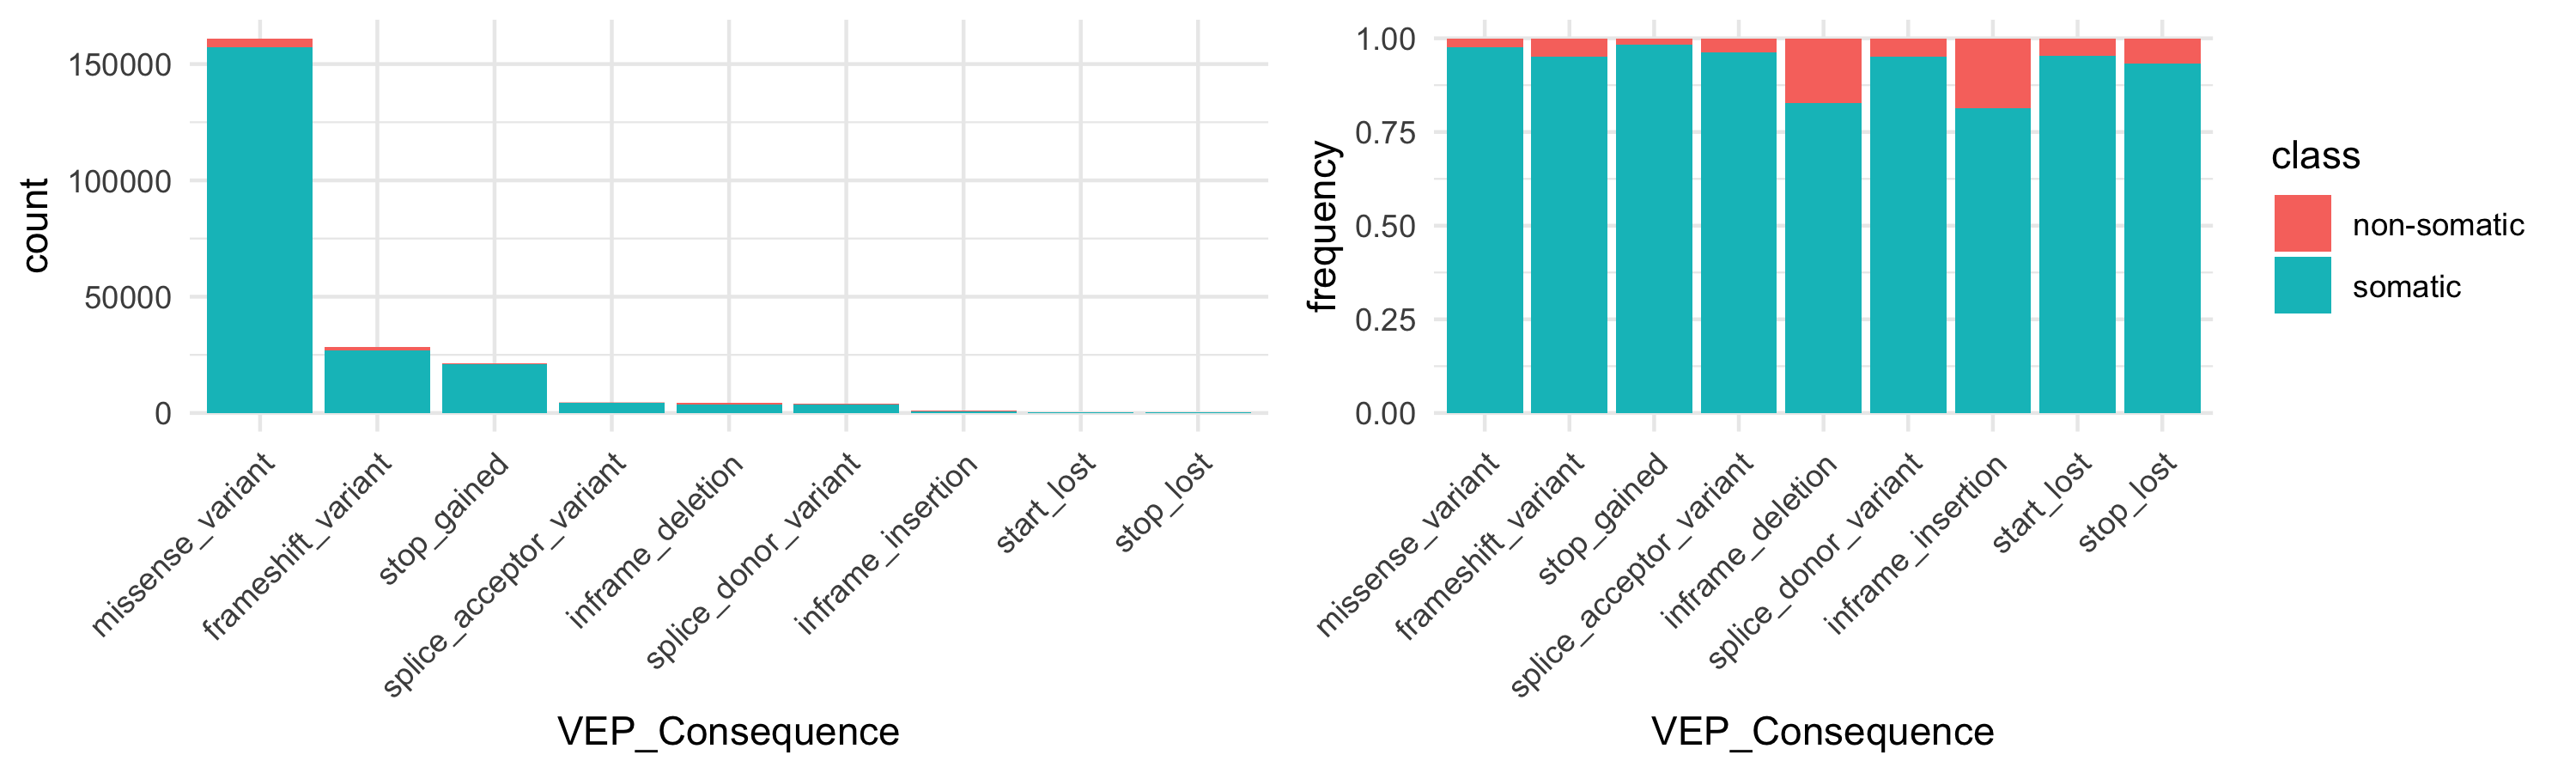

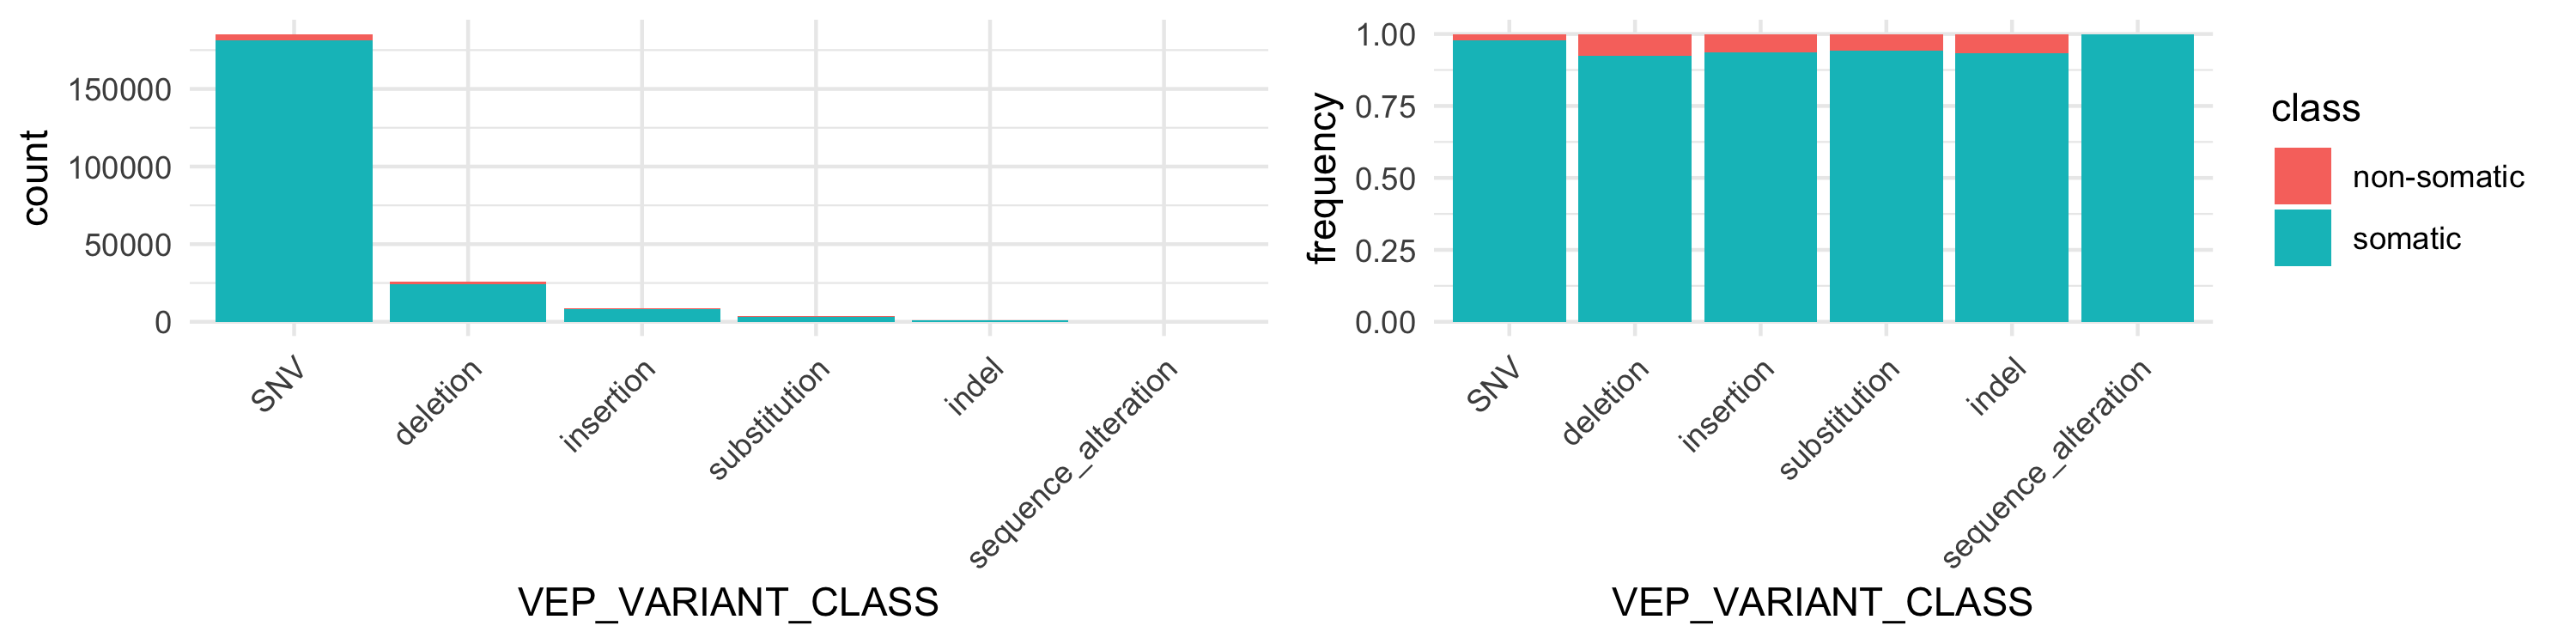

In [4]:
plot_contingency_table_as_histograms(impact, "VEP_Consequence", "class")
plot_contingency_table_as_histograms(impact, "VEP_VARIANT_CLASS", "class", 10, 2.5)

Nothing particularly interesting was found here, it does not seem the mutation `VEP_Consequence` or `VEP_VARIANT_CLASS` features have a clear impact on the `class` of the mutation. We can notice the relatively high amount of `non-somatic` in the `inframe_deletion` and `inframe_insertion` mutations.

## Comparison of the `frequency_in_normals`

Distribution of `frequency_in_normals` for the somatic vs non-somatic `class` (warning this plot concerns only the non-null `frequency_in_normals` ie 1.92% of the data):

[1] "4327 over 225022 (1.92%)"

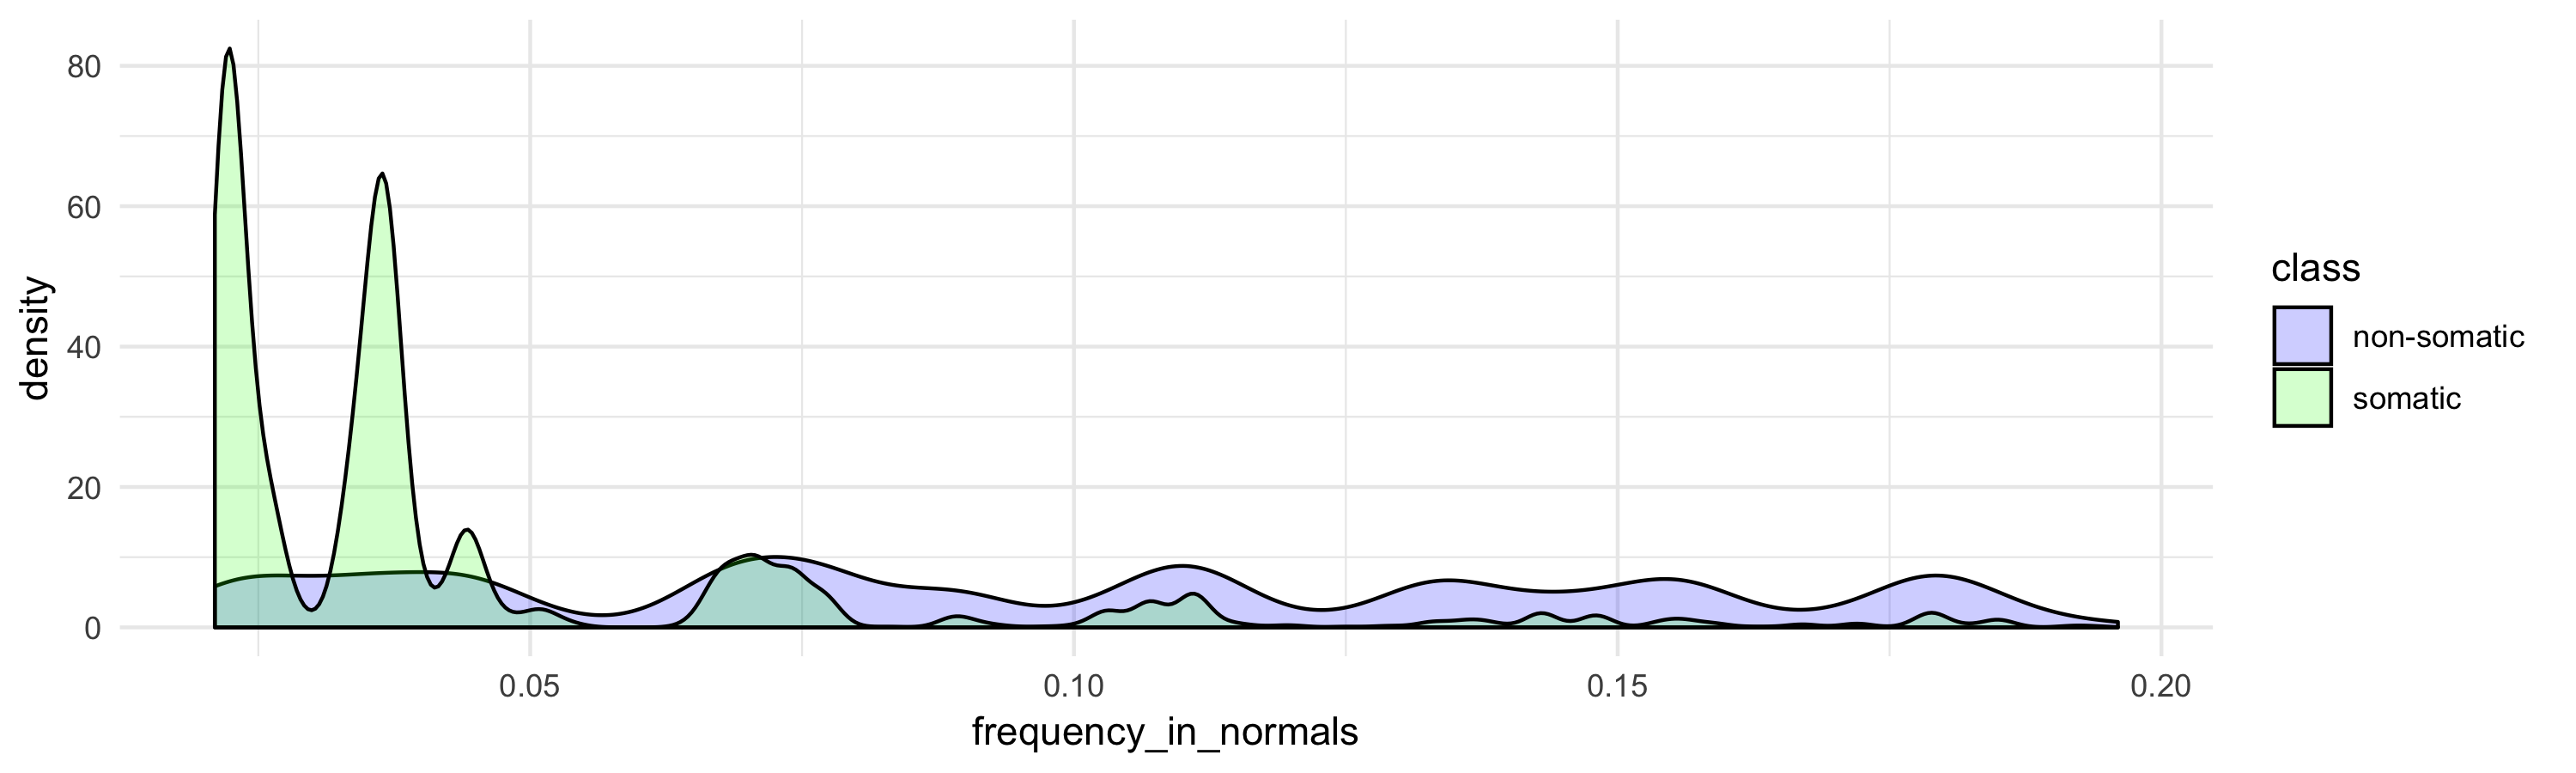

In [5]:
print_count_and_proportion(nrow(impact[impact$frequency_in_normals != 0,]), nrow(impact))
plot_density(impact[impact$frequency_in_normals != 0,], "frequency_in_normals", "class", adjust = 0.5)

Overall the non-somatic mutations are, as expected, more present in normals (due to the germline part). However there are some somatic mutations with a not-so-close-to-0 `frequency_in_normals`:

[1] 2516

[1] 230

[1] 0

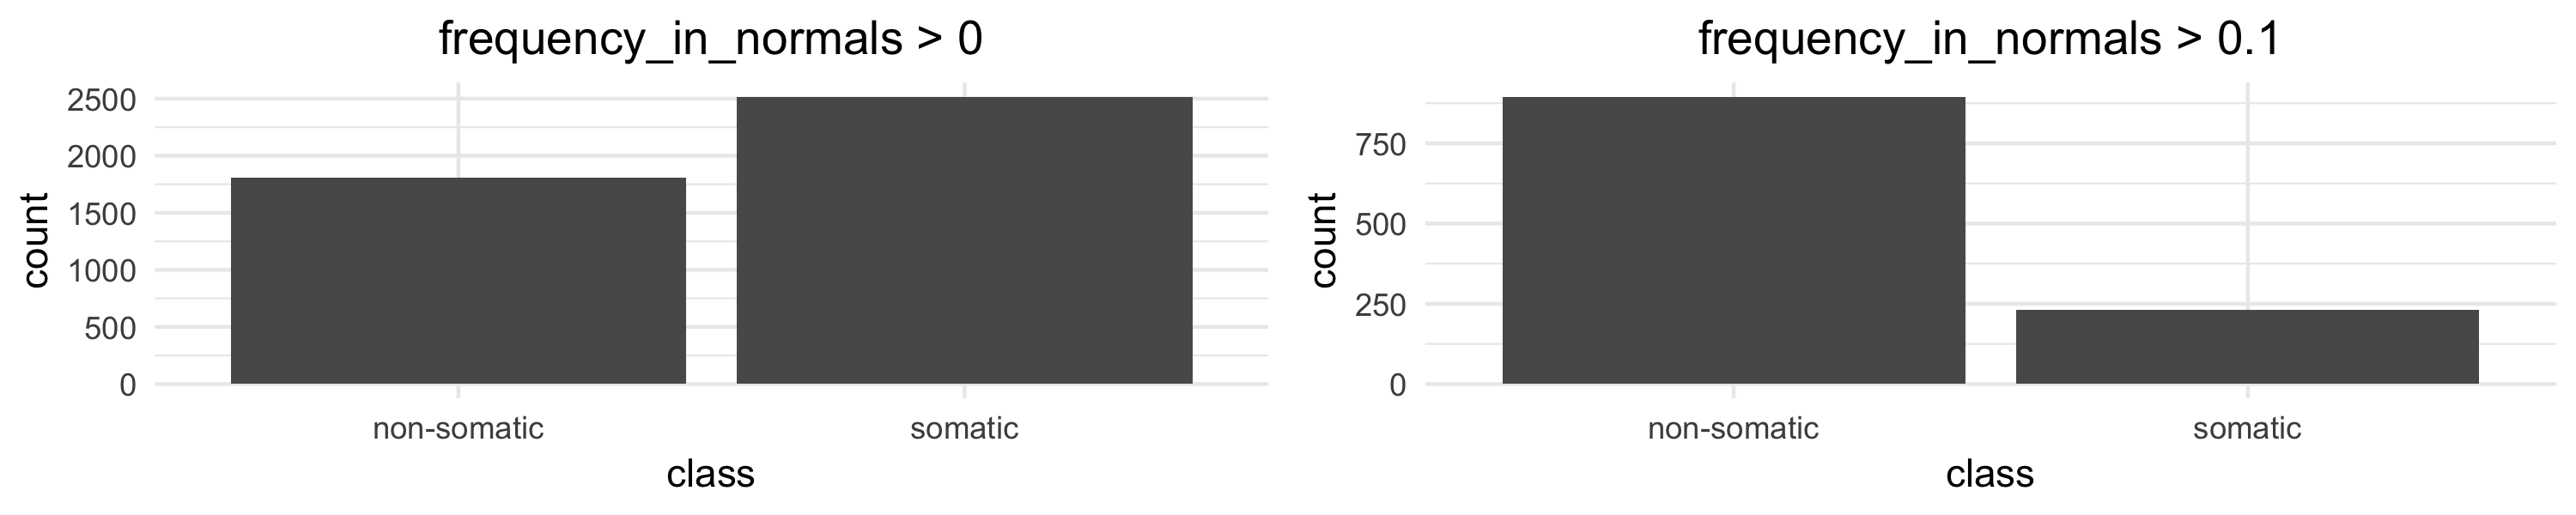

In [6]:
nrow(impact[impact$frequency_in_normals > 0   & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.2 & impact$class == "somatic",])

set_notebook_plot_size(6, 2)
plot1 <- ggplot(impact[impact$frequency_in_normals > 0  ,]) + geom_bar(aes(class)) + ggtitle("frequency_in_normals > 0"  ) + theme(plot.title = element_text(hjust = 0.5))
plot2 <- ggplot(impact[impact$frequency_in_normals > 0.1,]) + geom_bar(aes(class)) + ggtitle("frequency_in_normals > 0.1") + theme(plot.title = element_text(hjust = 0.5))
plot_side_by_side(plot1, plot2)

## Comparison of the `t_vaf`

Distribution of `t_vaf` for the somatic vs non-somatic `class`:

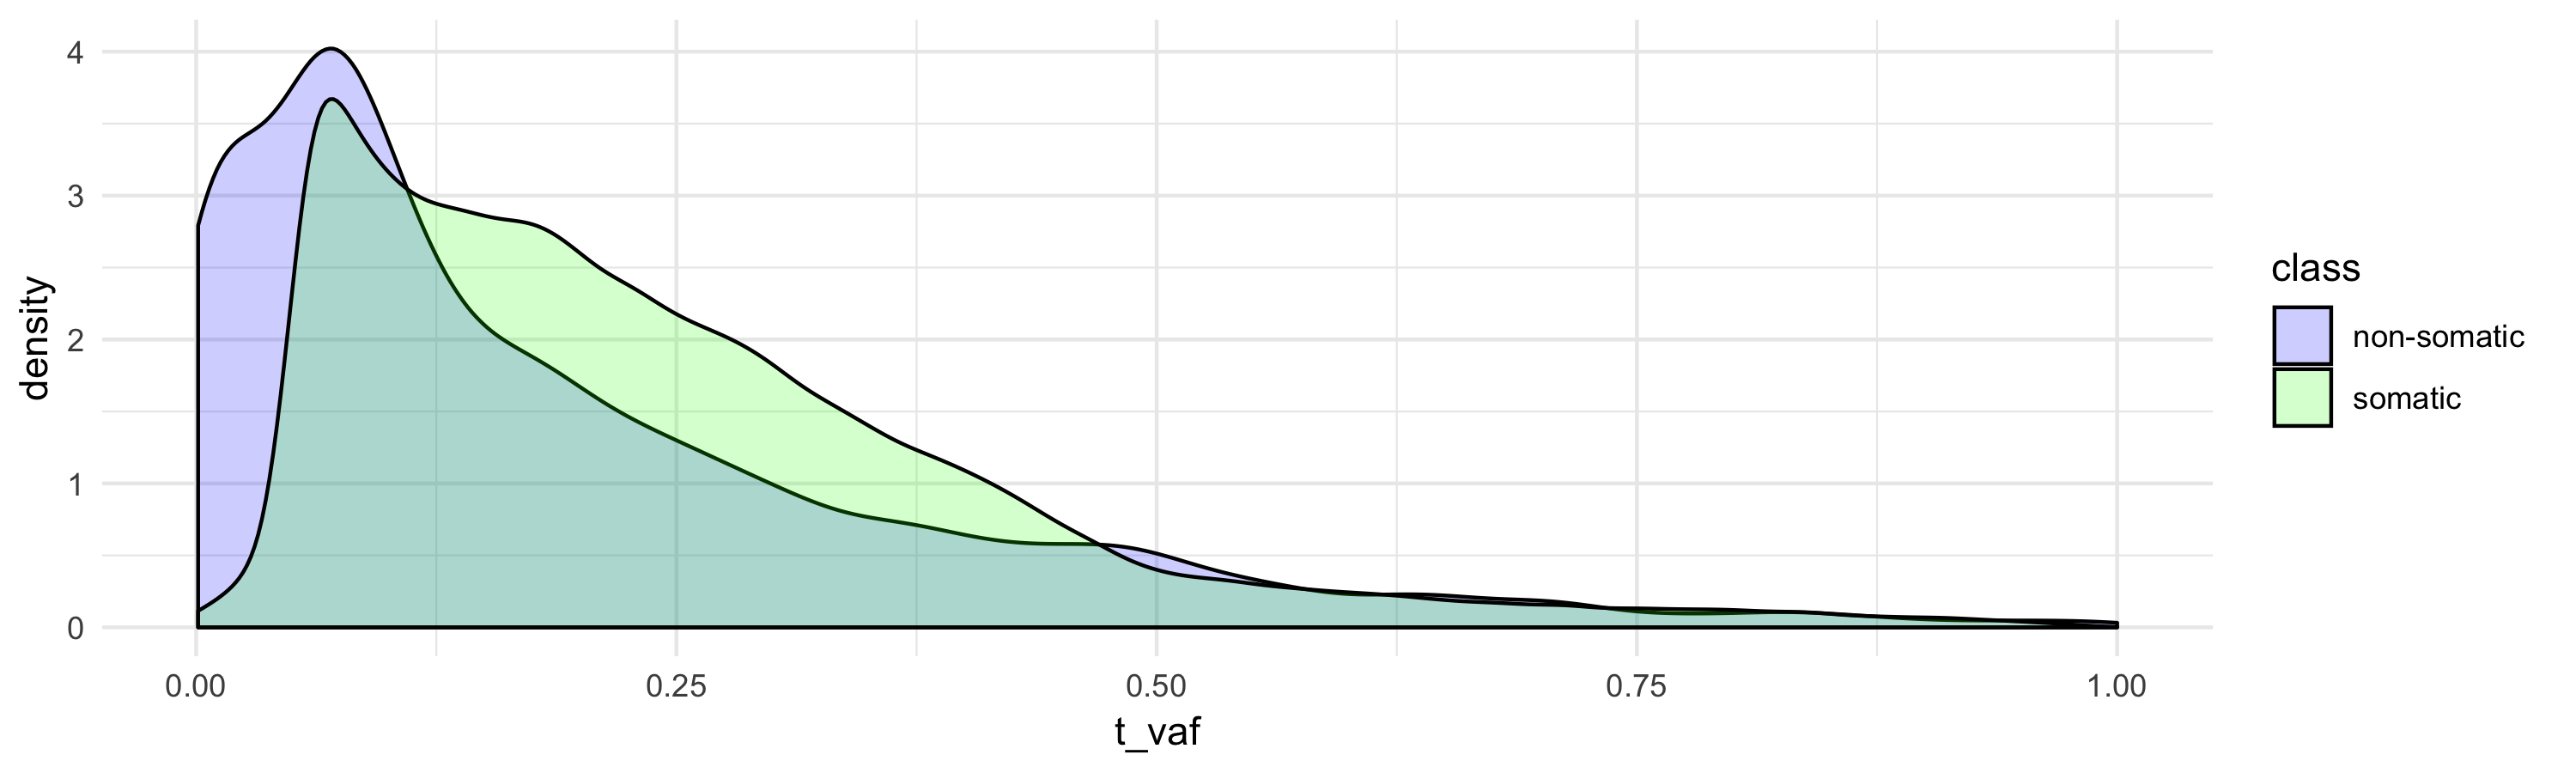

In [7]:
plot_density(impact, "t_vaf", "class")

As expected, the non-somatic density has a small peak at 0.5 (ie the likely germline calls), and a peak at low VAF (ie the likely artefacts calls).

## Comparison of the strand bias

We evaluate the `strand_ratio` for each mutation as:
$$\text{strand_ratio}\ =\ \frac{\min(\text{t_alt_neg_count}, \text{t_alt_plus_count})}
                              {\max(\text{t_alt_neg_count}, \text{t_alt_plus_count})}$$
                              
e.g. the lowest count over the maximum count, thus giving a result between 0 and 1 (1 being a low strand bias, because the count for the neg and pos are the same).

In [8]:
impact$strand_ratio <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                       pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `strand_ratio` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

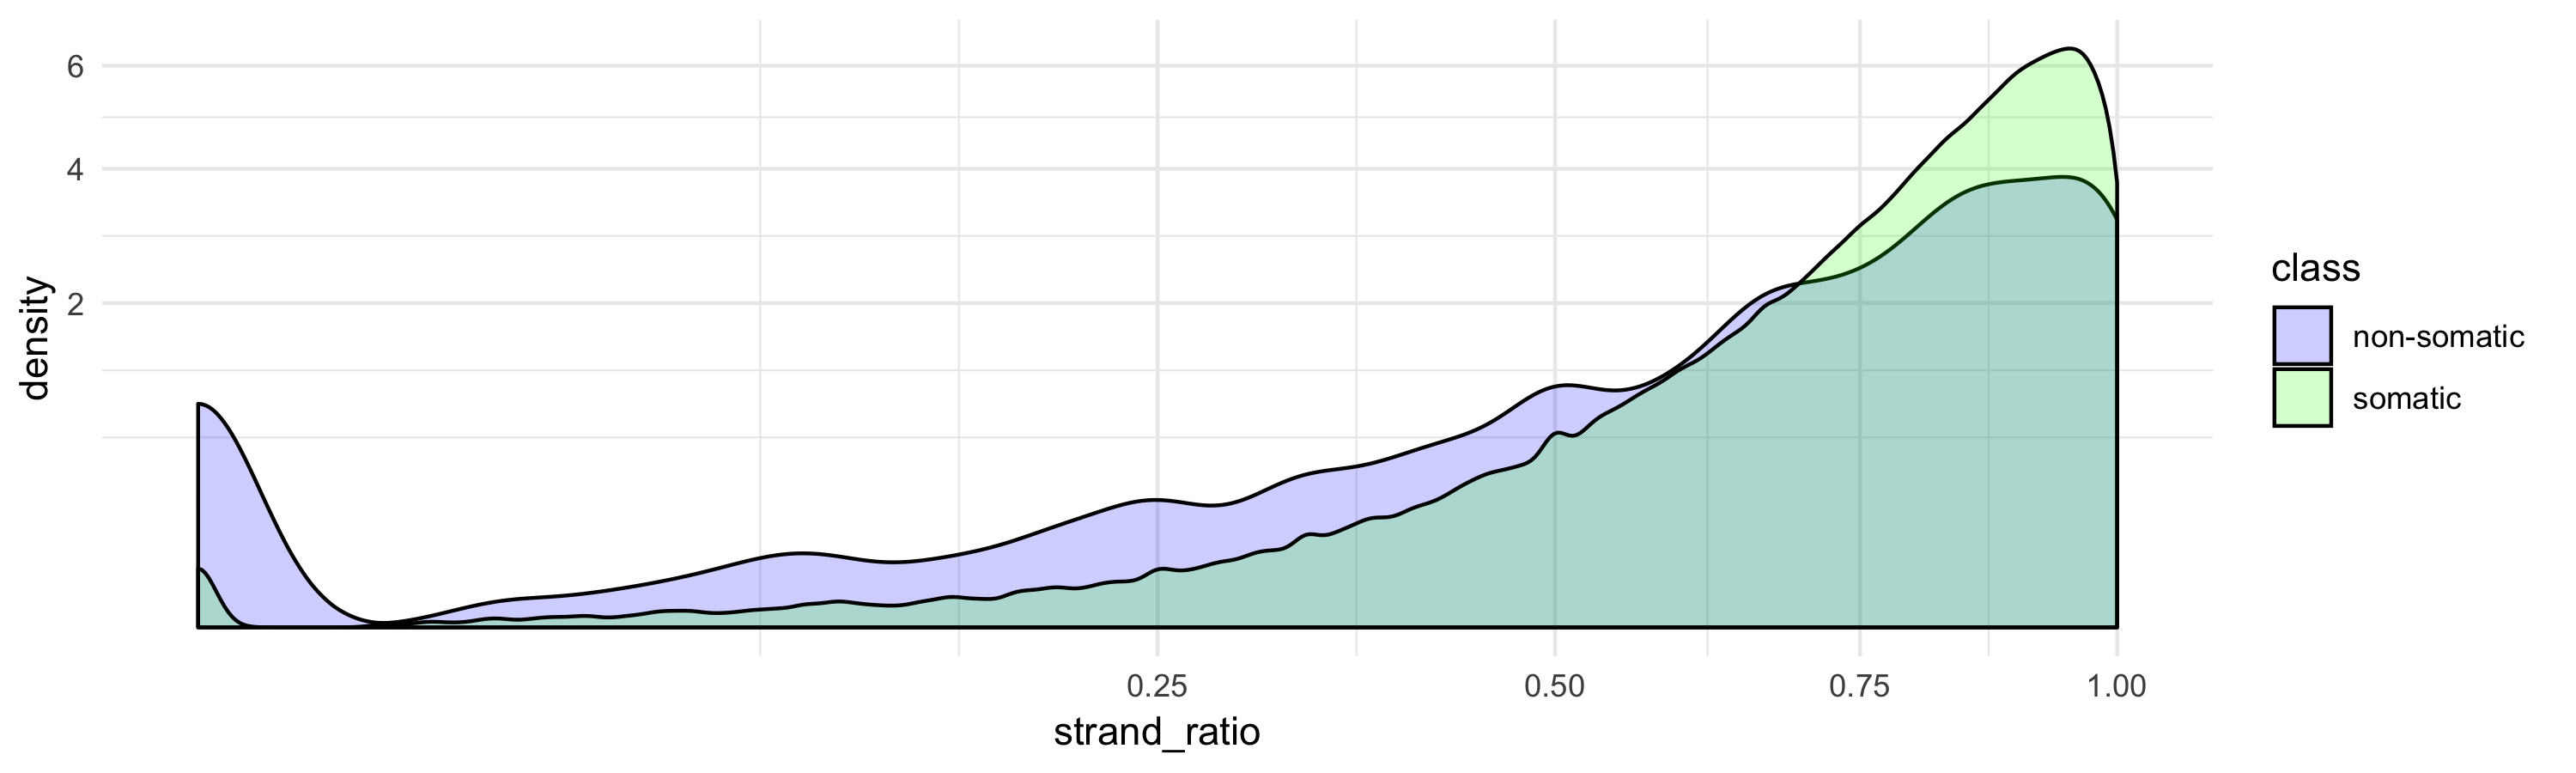

In [9]:
plot_density(impact, "strand_ratio", "class") + scale_x_sqrt() + scale_y_sqrt()

As expected, the non-somatic density has a heavier low strand ratio tail (likely from the artefact calls).

## `strand_ratio` vs `t_vaf`

Below is an attempt to plot the `strand_ratio` vs the `t_vaf` to separate the germline (`t_vaf` $\approx 0.5$ and high `strand_ratio`) from the artefact (low `t_vaf` and low `strand_ratio`):

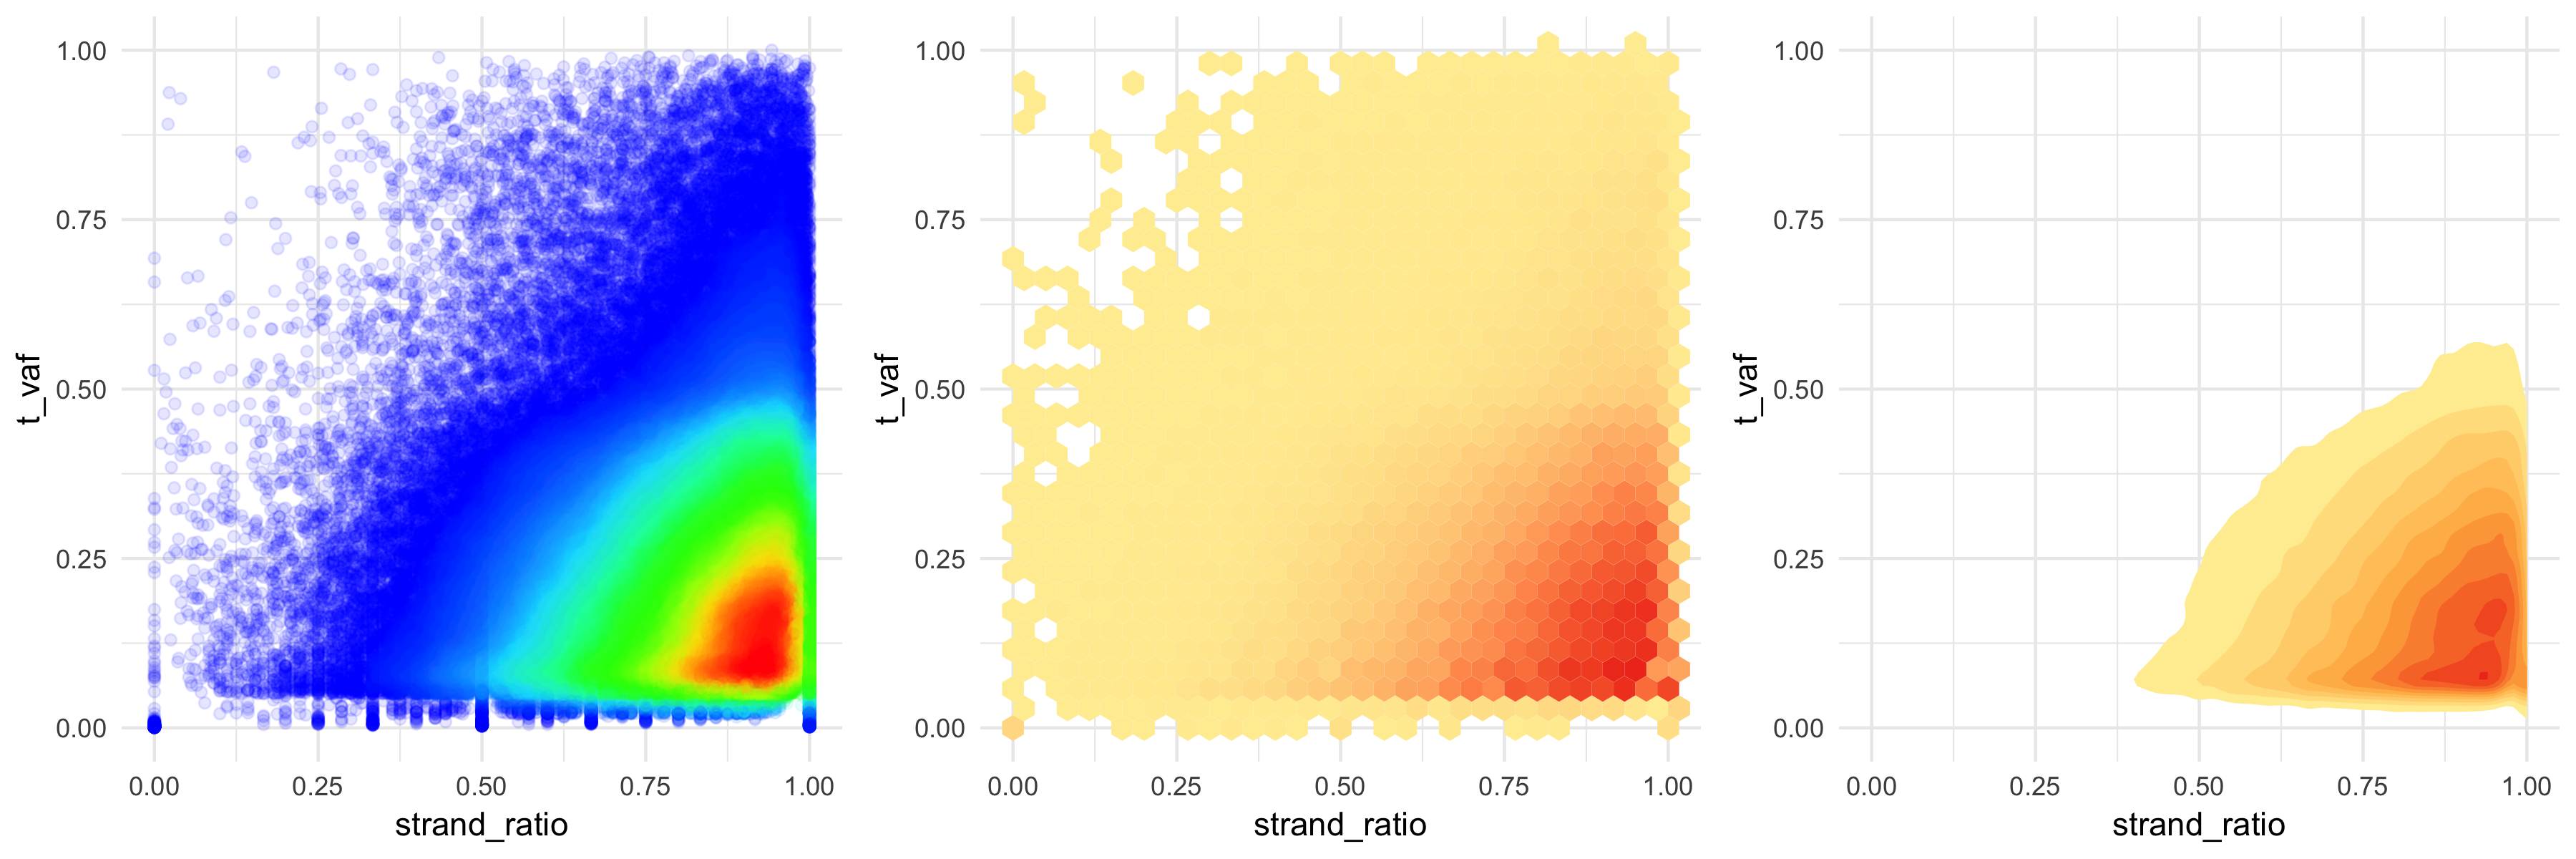

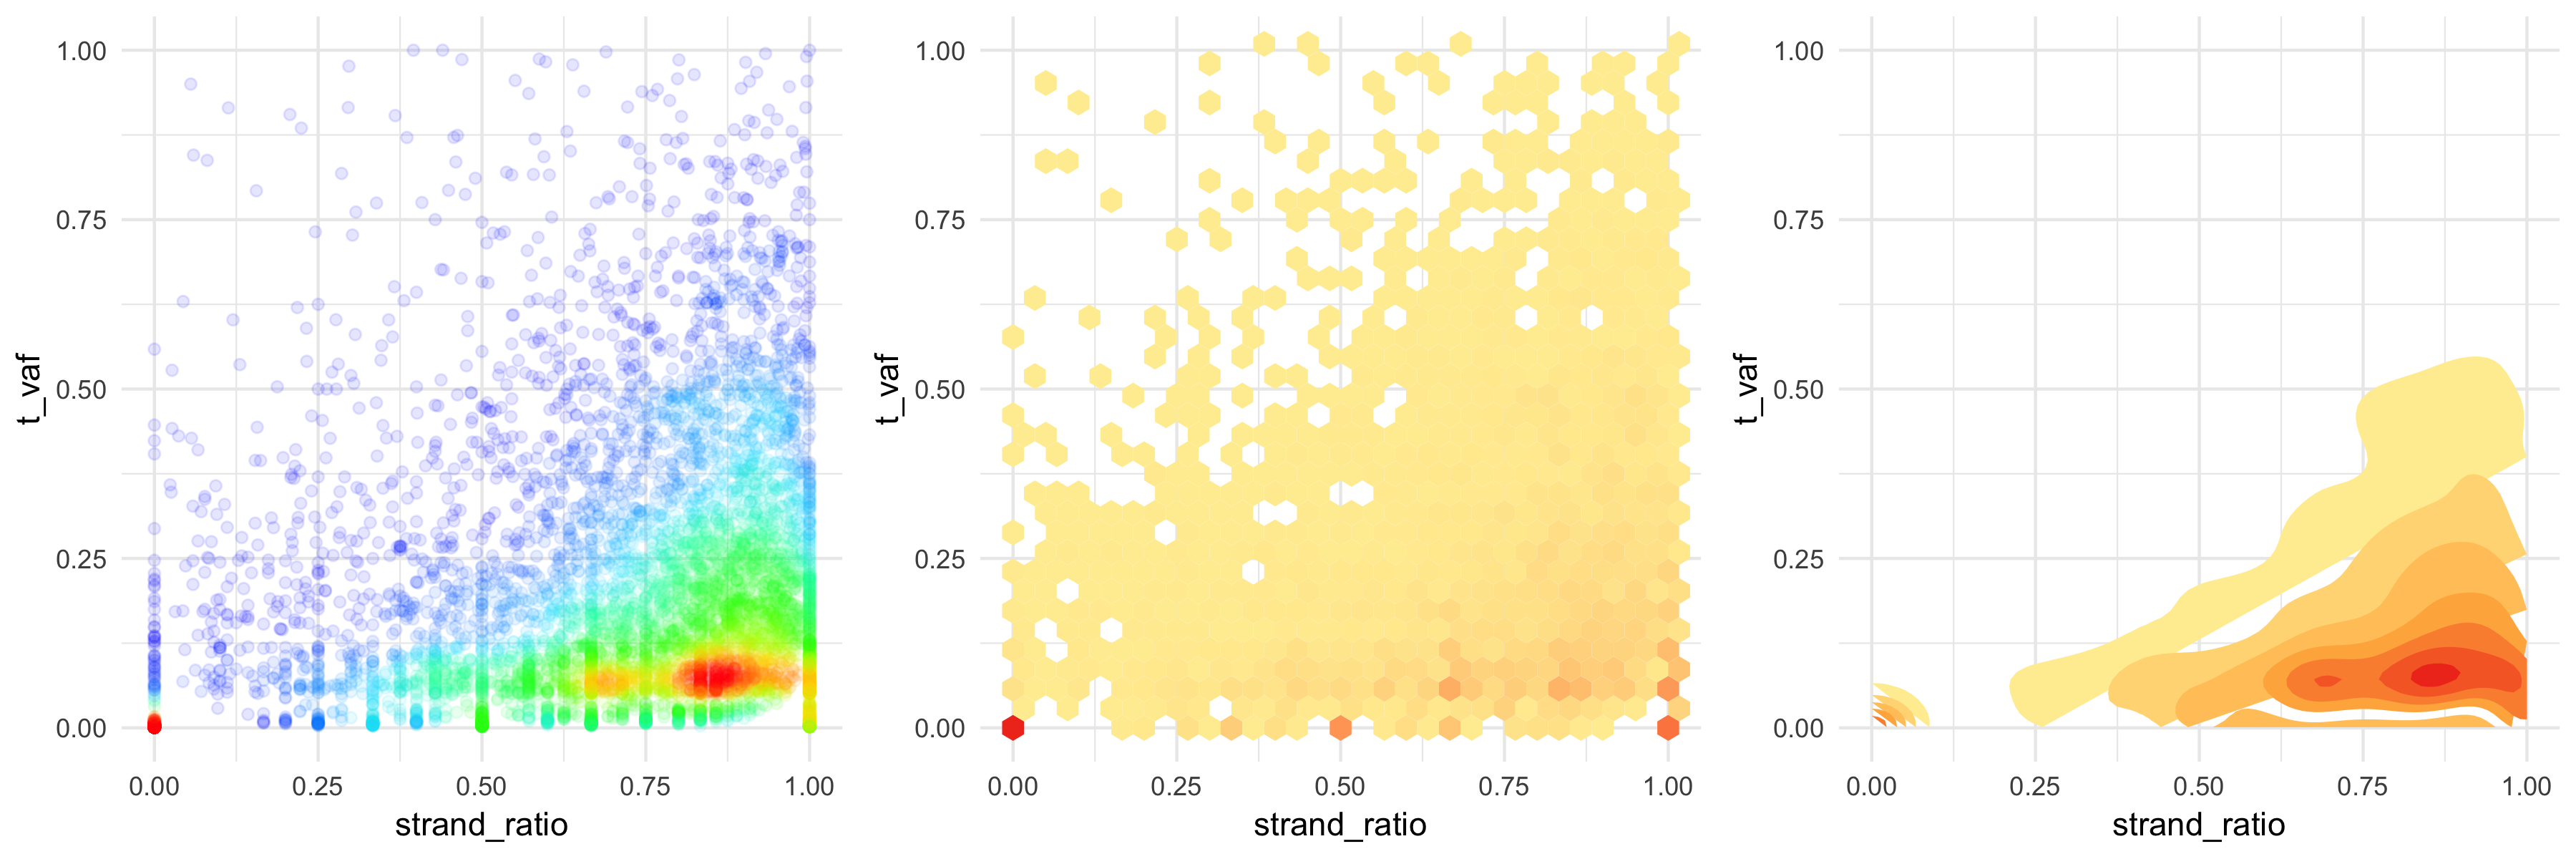

In [10]:
plot_density_2d(impact[impact$class == "somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))
plot_density_2d(impact[impact$class == "non-somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))

We clearly see the domain of the germline with a peak at `t_vaf = 0.5` in the lower graphs.

## Comparison of `VEP_gnomAD_total_AF`

Distribution of `VEP_gnomAD_total_AF` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

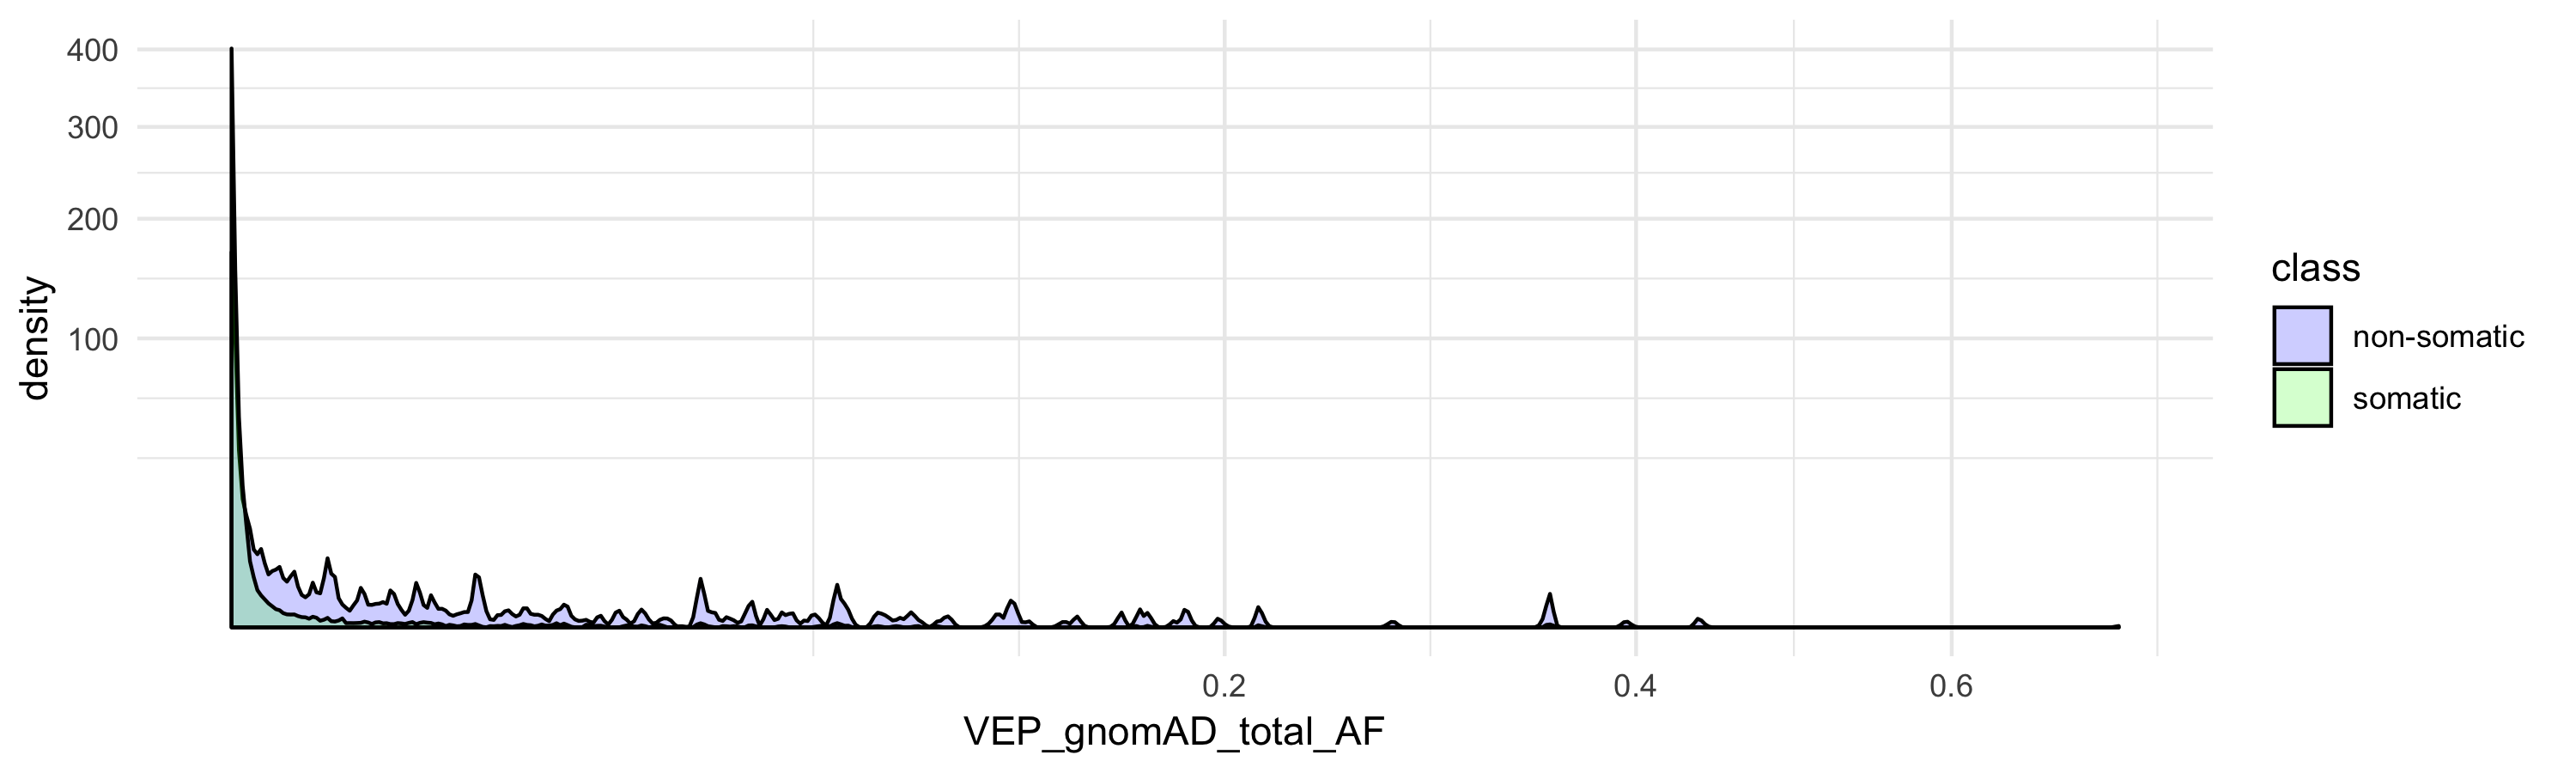

In [11]:
plot_density(impact, "VEP_gnomAD_total_AF", "class") + scale_x_sqrt() + scale_y_sqrt()

What was expected appears clearly, the `non-somatic` class presents a way longer tail on the higher `VEP_gnomAD_total_AF` value (due to the germline calls).

In [12]:
summary(impact$VEP_gnomAD_total_AF[impact$class == "somatic"])
summary(impact$VEP_gnomAD_total_AF[impact$class == "non-somatic"])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0000466 0.0000000 0.7221806 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0060613 0.0000713 0.4366926 

## Comparison of `VEP_COSMIC_CNT`

In [13]:
summary(impact$VEP_COSMIC_CNT[impact$class == "somatic"])
summary(impact$VEP_COSMIC_CNT[impact$class == "non-somatic"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   326.1     2.0 41311.0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     0.00    86.94     2.00 41311.00 

Distribution of `VEP_COSMIC_CNT` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `VEP_COSMIC_CNT` ie 33% of the data):

[1] "73911 over 225022 (32.85%)"

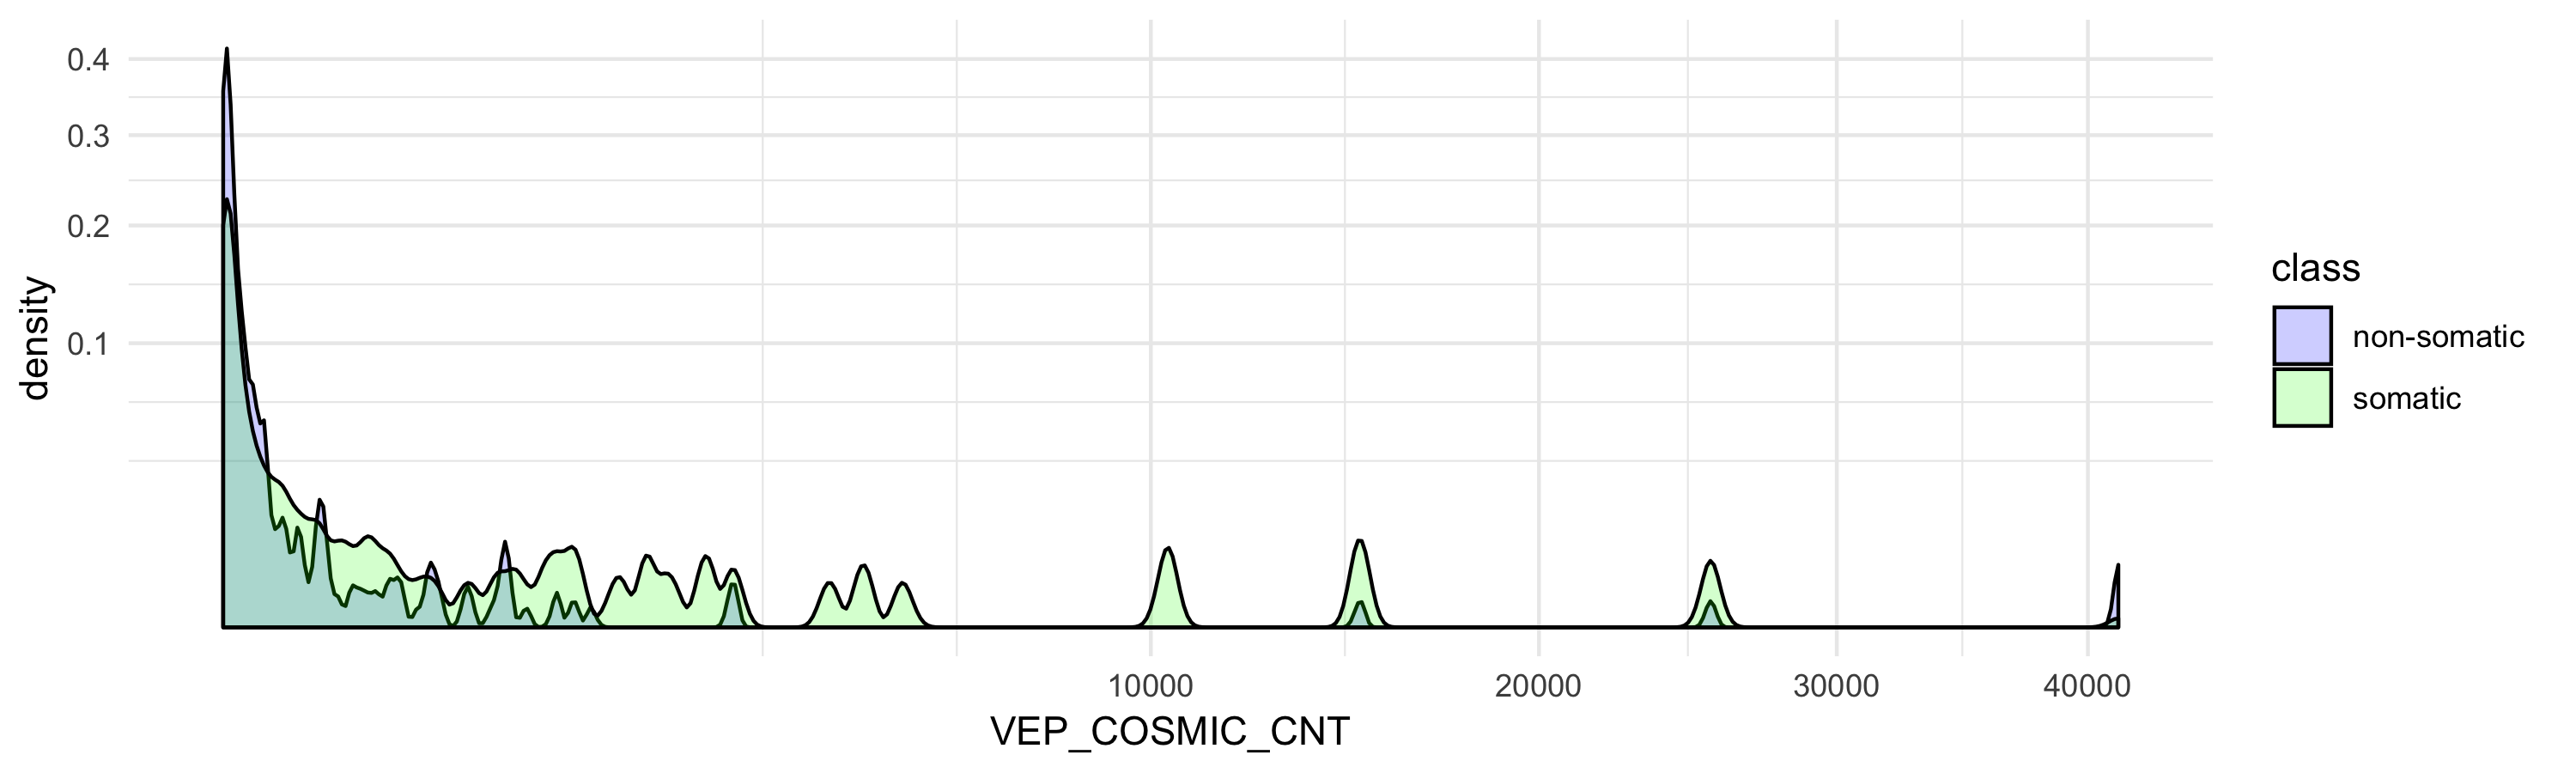

In [14]:
print_count_and_proportion(nrow(impact[impact$VEP_COSMIC_CNT != 0,]), nrow(impact))
plot_density(impact[impact$VEP_COSMIC_CNT != 0,], "VEP_COSMIC_CNT", "class") + scale_x_sqrt() + scale_y_sqrt()

We observe here that the mutations with a high `VEP_COSMIC_CNT` are mostly classified as somatic, even if some have been curated as non_somatic.

In [15]:
impact %>% filter(VEP_COSMIC_CNT >= 1000) %>%
           group_by(mut_key) %>%
           summarise(VEP_COSMIC_CNT  = unique(VEP_COSMIC_CNT),
                     VEP_SYMBOL      = unique(VEP_SYMBOL),
                     VEP_HGVSp       = unique(VEP_HGVSp),
                     VEP_Consequence = unique(VEP_Consequence),
                     n_somatic       = sum(class == "somatic"),
                     n_non_somatic   = sum(class == "non-somatic")) %>%
           filter(n_non_somatic != 0) %>%
           arrange(-VEP_COSMIC_CNT)

mut_key                                                           
1  9_5073770_G_T                                                     
2  7_140453136_A_T                                                   
3  12_25398284_C_T                                                   
4  17_7578406_C_T                                                    
5  19_13054565_GCAGAGGCTTAAGGAGGAGGAAGAAGACAAGAAACGCAAAGAGGAGGAGGAG_-
6  17_7577539_G_A                                                    
7  12_25398285_C_G                                                   
8  17_7578212_G_A                                                    
9  17_7577121_G_A                                                    
10 1_115256530_G_T                                                   
   VEP_COSMIC_CNT VEP_SYMBOL VEP_HGVSp VEP_Consequence      n_somatic
1  41311          JAK2       p.V617F   missense_variant       13     
2  25519          BRAF       p.V600E   missense_variant      715     
3  14959          KRAS       p.G12D    missense_variant     1299     
4   3068          TP53       p.R175H   missense_variant      579     
5   1621          CALR       unknown   splice_donor_variant    0     
6   1492          TP53       p.R248W   missense_variant      297     
7   1460          KRAS       p.G12R    missense_variant      234     
8   1345          TP53       p.R213*   stop_gained           251     
9   1336          TP53       p.R273C   missense_variant      364     
10  1109          NRAS       p.Q61K    missense_variant      142     
   n_non_somatic
1  10           
2   2           
3   2           
4   6           
5   1           
6   1           
7   1           
8   1           
9   2           
10  1

# The `mut_key` feature: study of reccurent mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [16]:
head(impact$mut_key)
length(unique(impact$mut_key)) # number of different keys e.g. number of different mutations

[1] "17_7577515_T_G"  "1_46521514_G_C"  "3_142178126_C_A" "4_55139732_T_A" 
[5] "4_153249542_C_A" "4_153332775_C_A"

[1] 150041

## Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [17]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact %>% group_by(patient_key) %>%
                                                               select(patient_key, mut_key, VEP_SYMBOL, VEP_Consequence, VEP_VARIANT_CLASS, class) %>%
                                                               filter(! duplicated(mut_key)))
nrow(impact)
nrow(impact_unique_mut_keys_per_patient)

[1] 225022

[1] 215867

In [18]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(count = n(), VEP_SYMBOL = unique(VEP_SYMBOL)))
head(mut_key_info)

mut_key        count VEP_SYMBOL
1 1_11167549_A_G 1     MTOR      
2 1_11168271_G_A 1     MTOR      
3 1_11168272_A_G 1     MTOR      
4 1_11168275_T_C 1     MTOR      
5 1_11168277_G_A 1     MTOR      
6 1_11168283_T_C 1     MTOR

In [19]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "14% (20598) of the keys are shared by at least  2 samples [40% (86424) of the rows concerned]"
[1] " 5% ( 7426) of the keys are shared by at least  3 samples [28% (60080) of the rows concerned]"
[1] " 2% ( 2646) of the keys are shared by at least  5 samples [21% (44419) of the rows concerned]"
[1] " 1% (  969) of the keys are shared by at least 10 samples [16% (34037) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples:

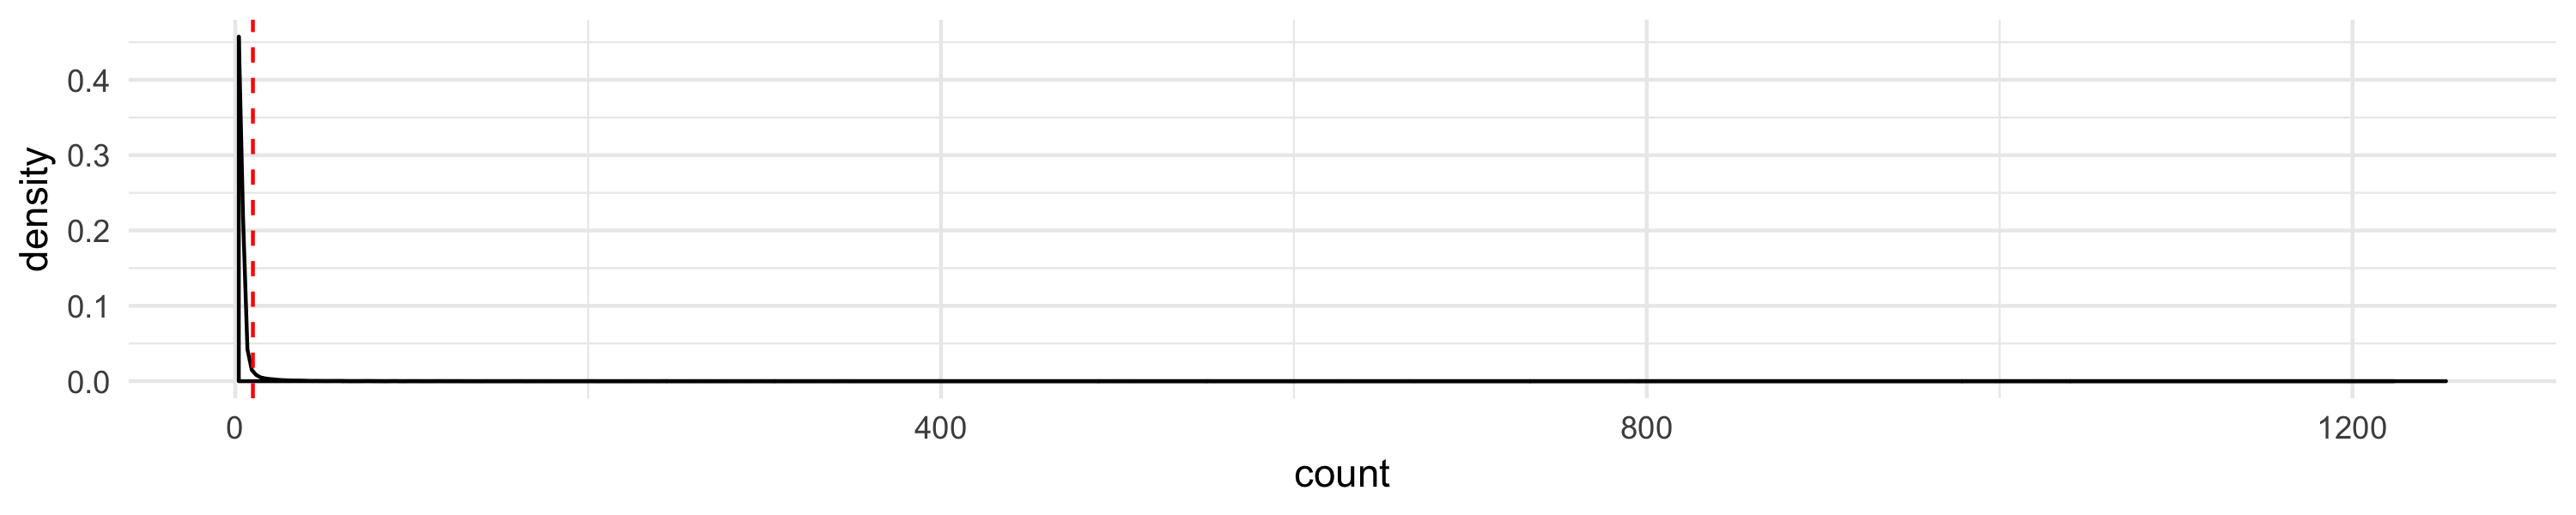

In [20]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
plot_density(repeated_key, "count", adjust = 5, lines = 10, height = 2)

## Sudy the reccurent mutations genes

In [21]:
length(unique(repeated_key$VEP_SYMBOL))

[1] 465

In [22]:
head(repeated_key)

mut_key        count VEP_SYMBOL
19 1_11169376_A_T 3     MTOR      
20 1_11169377_T_A 3     MTOR      
25 1_11169741_G_A 3     MTOR      
31 1_11174379_C_T 2     MTOR      
33 1_11174386_C_A 3     MTOR      
34 1_11174395_A_C 4     MTOR

Here is a plot of the genes that are the most mutated **accross the mutation keys**:

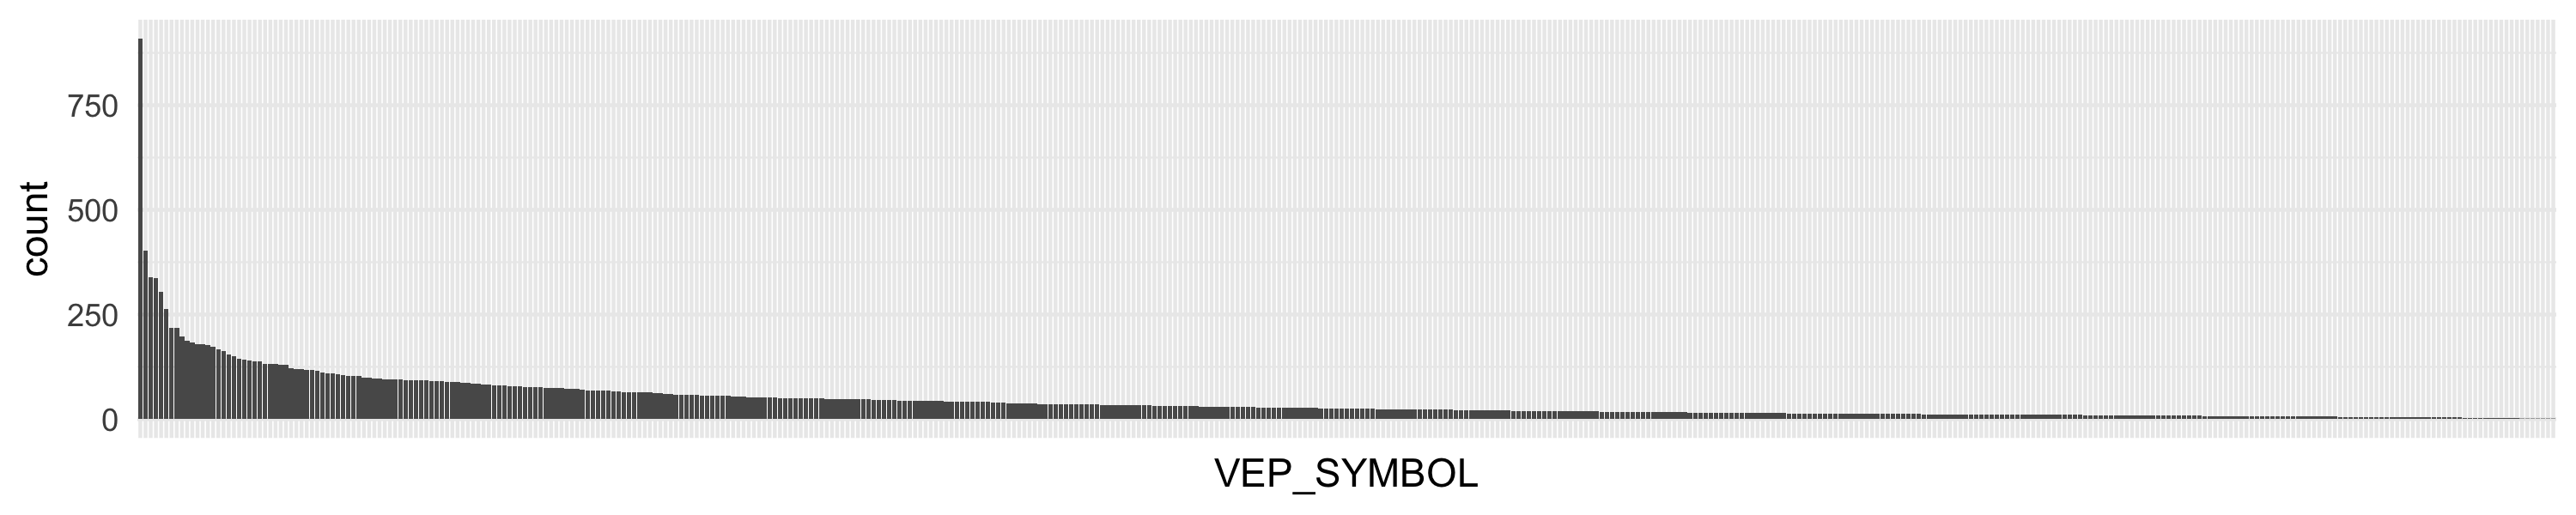

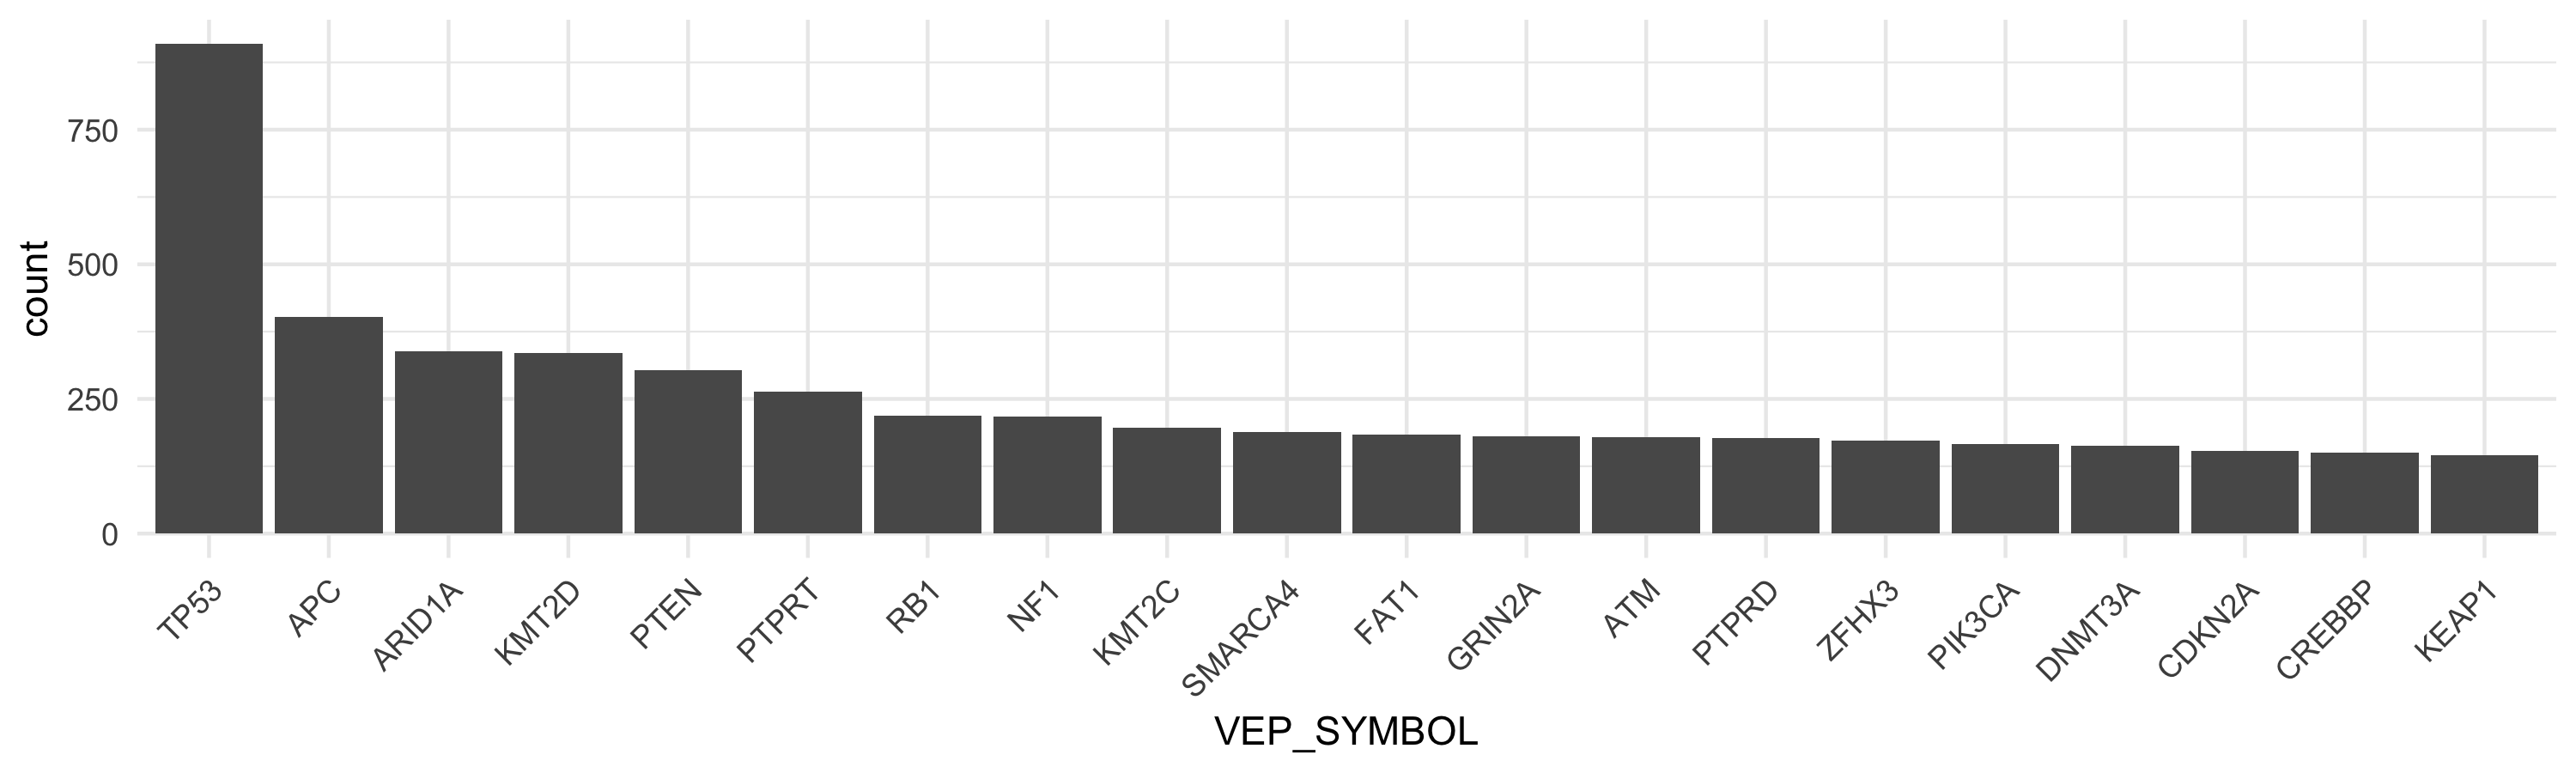

In [23]:
repeated_key <- sort_histogram(repeated_key, "VEP_SYMBOL")
set_notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(VEP_SYMBOL)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "VEP_SYMBOL", 20) + tilt_x_label(45)

Here is a plot of the genes that are the most mutated **accross the rows**:

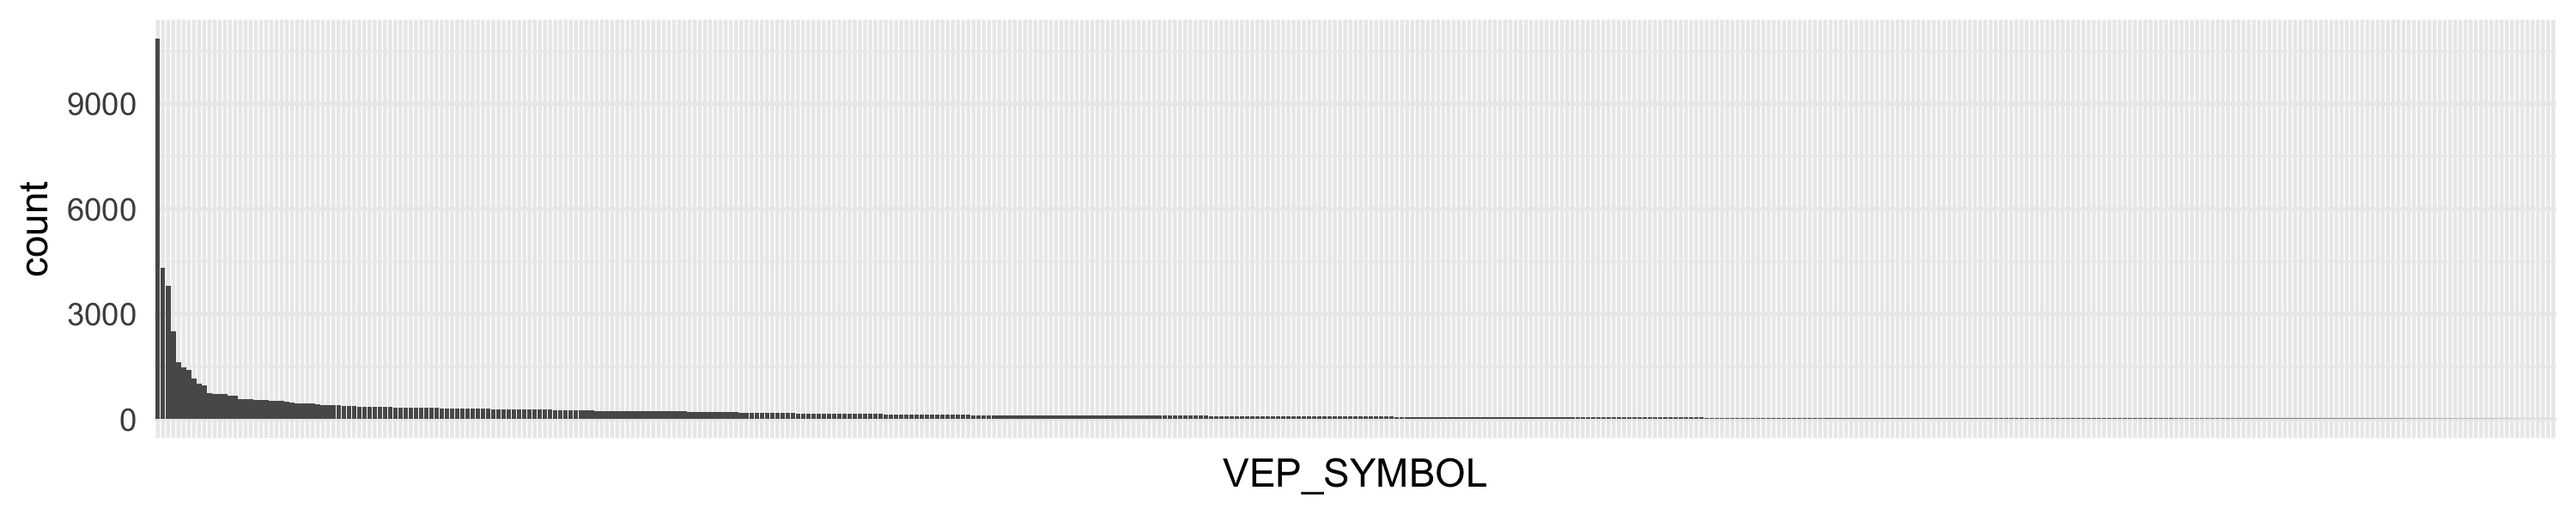

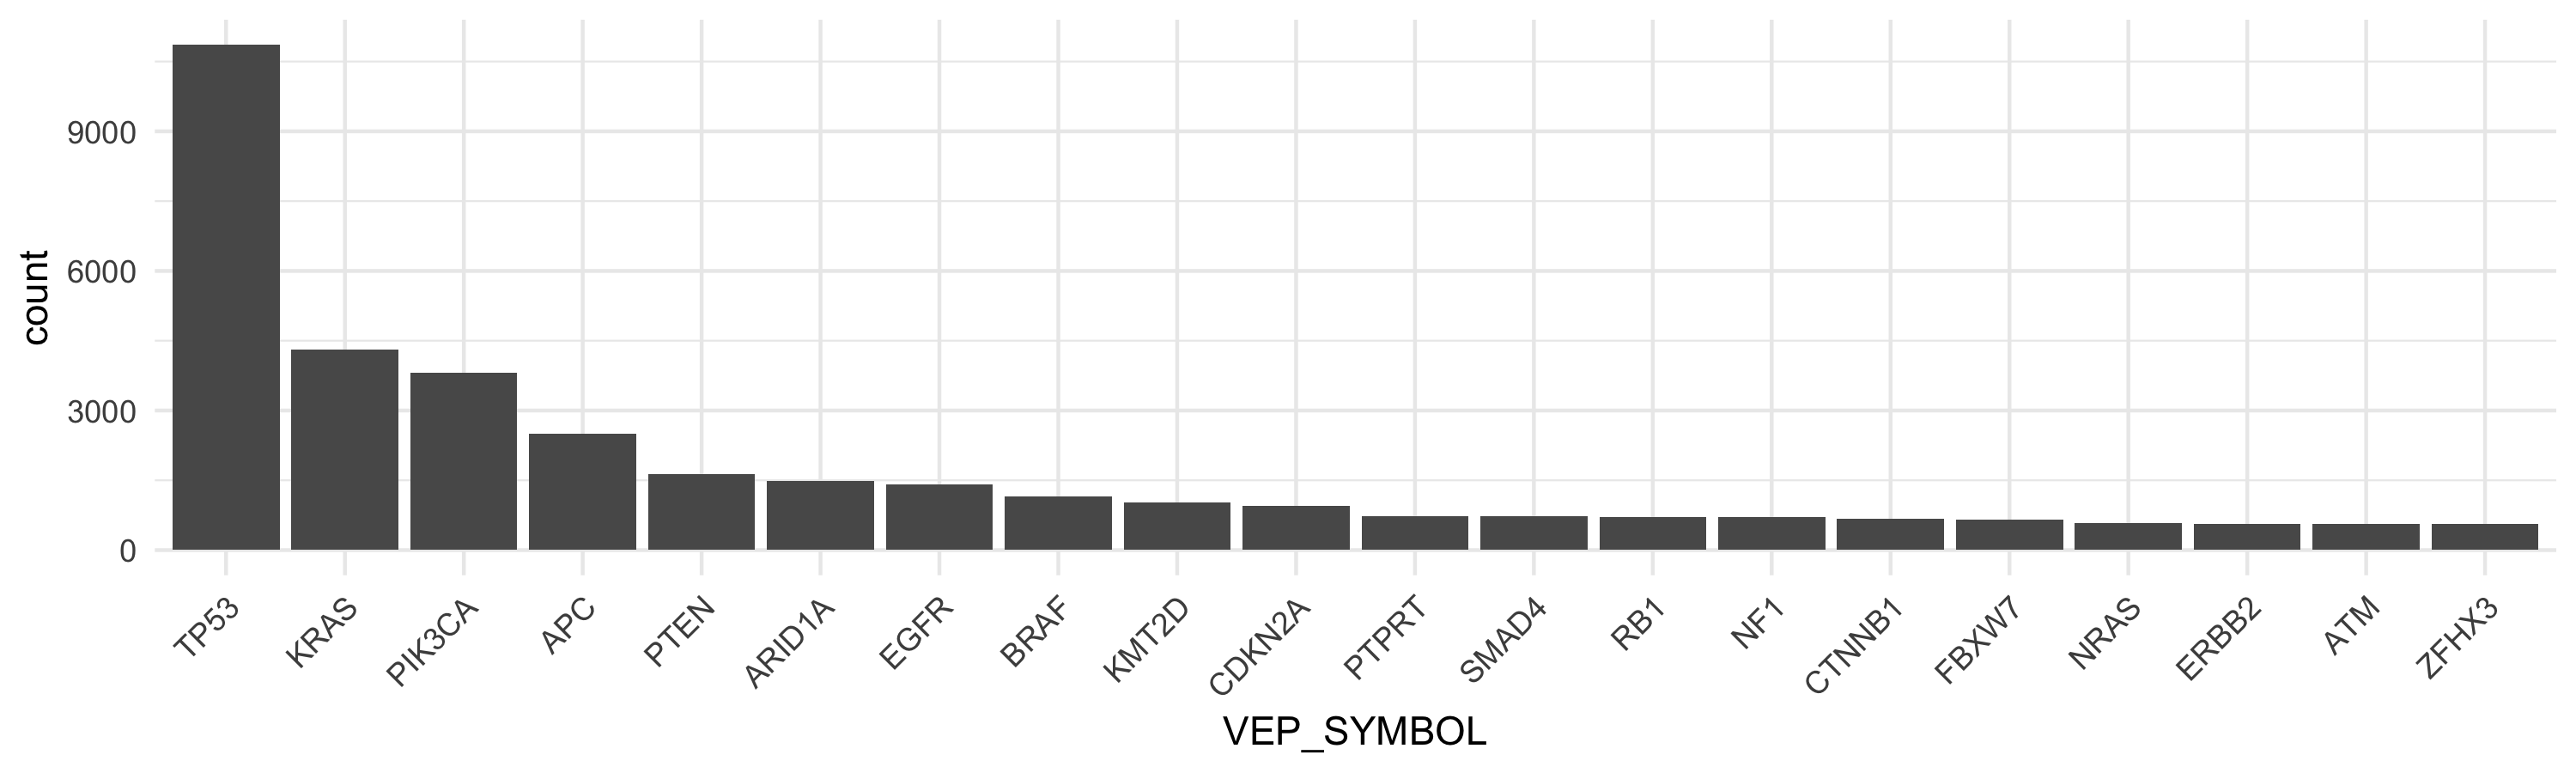

In [24]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "VEP_SYMBOL")
set_notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(VEP_SYMBOL)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "VEP_SYMBOL", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Study of the proportion of inconsistent features

The mutations sharing the same key should have the same `class`, we evaluate the number of keys and mutations which have different `class` values (e.g the number of mutations classified as `somatic` once and `non-somatic` another time):

In [25]:
keys_inconsistent_class <- impact %>% filter(mut_key %in% repeated_key$mut_key) %>%
                                      group_by(mut_key) %>%
                                      summarise(count = n(),
                                                n_class = length(unique(class)),
                                                n_somatic = sum(class == "somatic"),
                                                n_non_somatic = sum(class == "non-somatic"),
                                                prop_somatic = n_somatic / count,
                                                n_min = min(n_somatic, n_non_somatic)) %>%
                                      filter(n_class > 1)

sprintf("%.2f%% (%d) keys with inconsistent class ie %.2f%% (%d) of the mutations",
        nrow(keys_inconsistent_class) / length(unique(impact$mut_key)) * 100,
        nrow(keys_inconsistent_class),
        nrow(impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]) / nrow(impact) * 100, 
        nrow(impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]))

[1] "0.64% (959) keys with inconsistent class ie 5.86% (13190) of the mutations"

In [26]:
print_count_and_proportion(nrow(impact[impact$class == "non-somatic" &
                                       impact$mut_key %in% keys_inconsistent_class$mut_key,]),
                           nrow(impact[impact$class == "non-somatic",]))
print_count_and_proportion(nrow(impact[impact$class == "somatic" &
                                       impact$mut_key %in% keys_inconsistent_class$mut_key,]),
                           nrow(impact[impact$class == "somatic",]))

[1] "2539 over 6849 (37.07%)"

[1] "10651 over 218173 (4.88%)"

$5.86\%$ of the rows have a controversed class (37% of the `non-somatic` and 5% of the `somatic`) ! However, sometimes as we saw during the `cosmic_count` study, we have 100 rows being classified as `somatic` and 2 as `non_somatic`. Suppose we would like to re-label the `class` feature, by re-labelling with the highest class count number (ie in the previous example 2 rows relabeled as `non-somatic`), and let's count the number of rows to re-label:

In [27]:
sprintf("%.2f%% (%d) of the mutations",
        sum(keys_inconsistent_class$n_min) / nrow(impact) * 100,
        sum(keys_inconsistent_class$n_min))

[1] "0.72% (1622) of the mutations"

Now we want to have an idea of the error: among the inconsistent labels is it always 50% somatic and 50% non-somatic, is it mostly somatic and sometimes non-somatic, is it another repartition? The plot below shows the repartition of the proportion of somatic among the inconsistent `keys`:

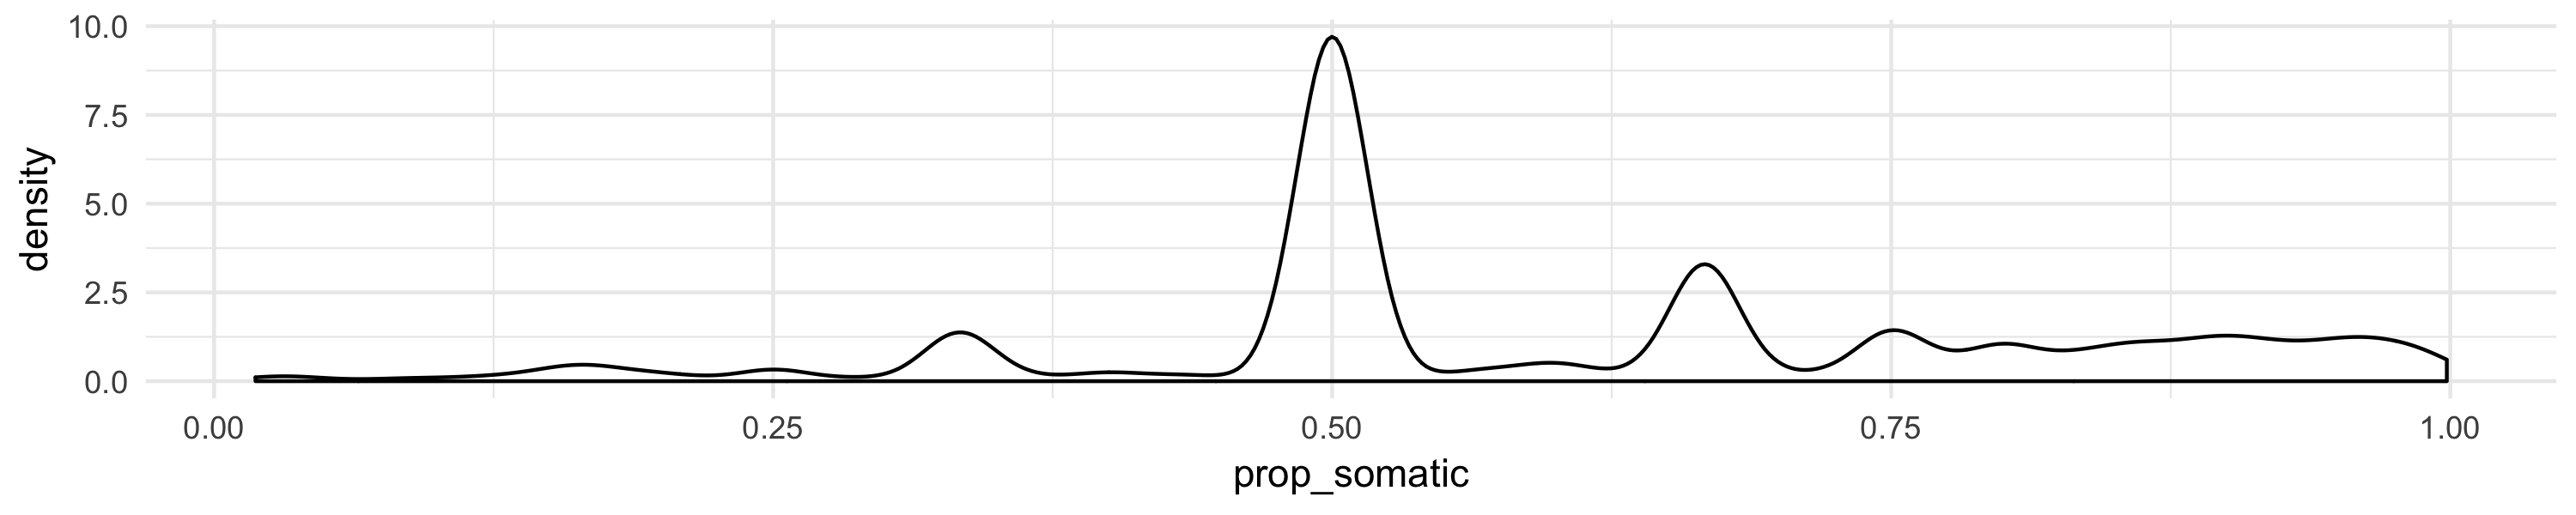

In [28]:
plot_density(keys_inconsistent_class, "prop_somatic", height = 2, adjust = 1/3)

So the errors are more uncertainity than real errors: in most cases, the mutation was equally classified as `somatic` than as `non-somatic`. However, when we study the keys that are shared by more than 5 rows, it seems that most of them are somatic mutations sometimes wrongly classified as `non-somatic`:

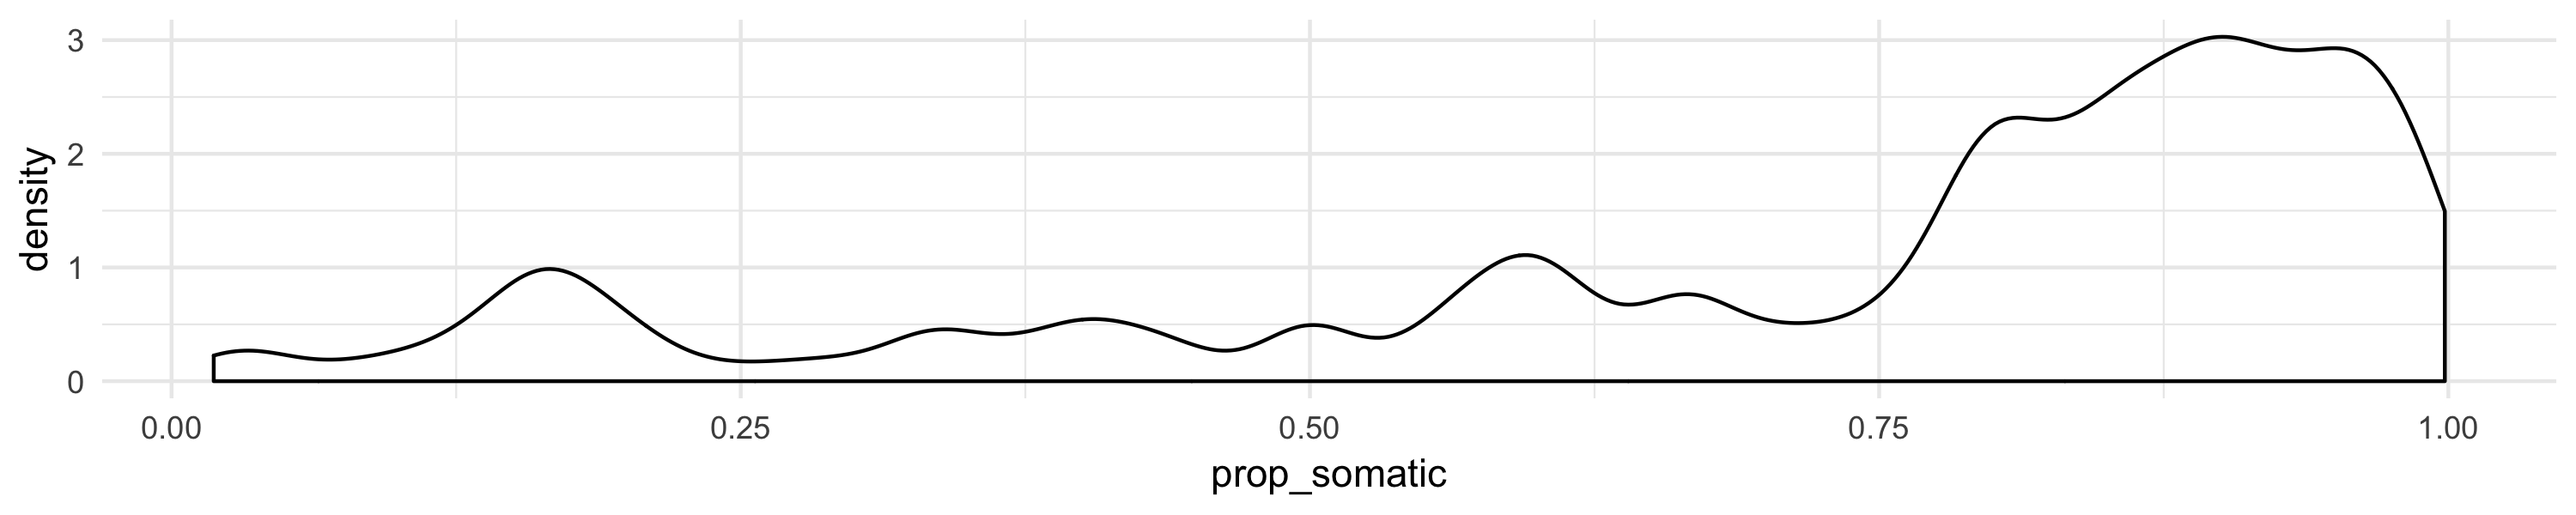

In [29]:
plot_density(keys_inconsistent_class[keys_inconsistent_class$count >= 5,], "prop_somatic", height = 2, adjust = 1/3)

So we have two types of inconsistence:
* keys were we don't know between `somatic` and `non-somatic` (~60%)
* keys that are most of the time `somatic` and sometimes classified as `non-somatic` (~40%)

In [30]:
print_count_and_proportion(nrow(keys_inconsistent_class[keys_inconsistent_class$count >= 5,]),
                           nrow(keys_inconsistent_class))

[1] "391 over 959 (40.77%)"

In [31]:
dd <- impact[impact$mut_key %in% keys_inconsistent_class$mut_key,]
impact$category <- "all mutations"
dd$category <- "inconsistent confidence_class"
dd <- rbind(impact, dd)

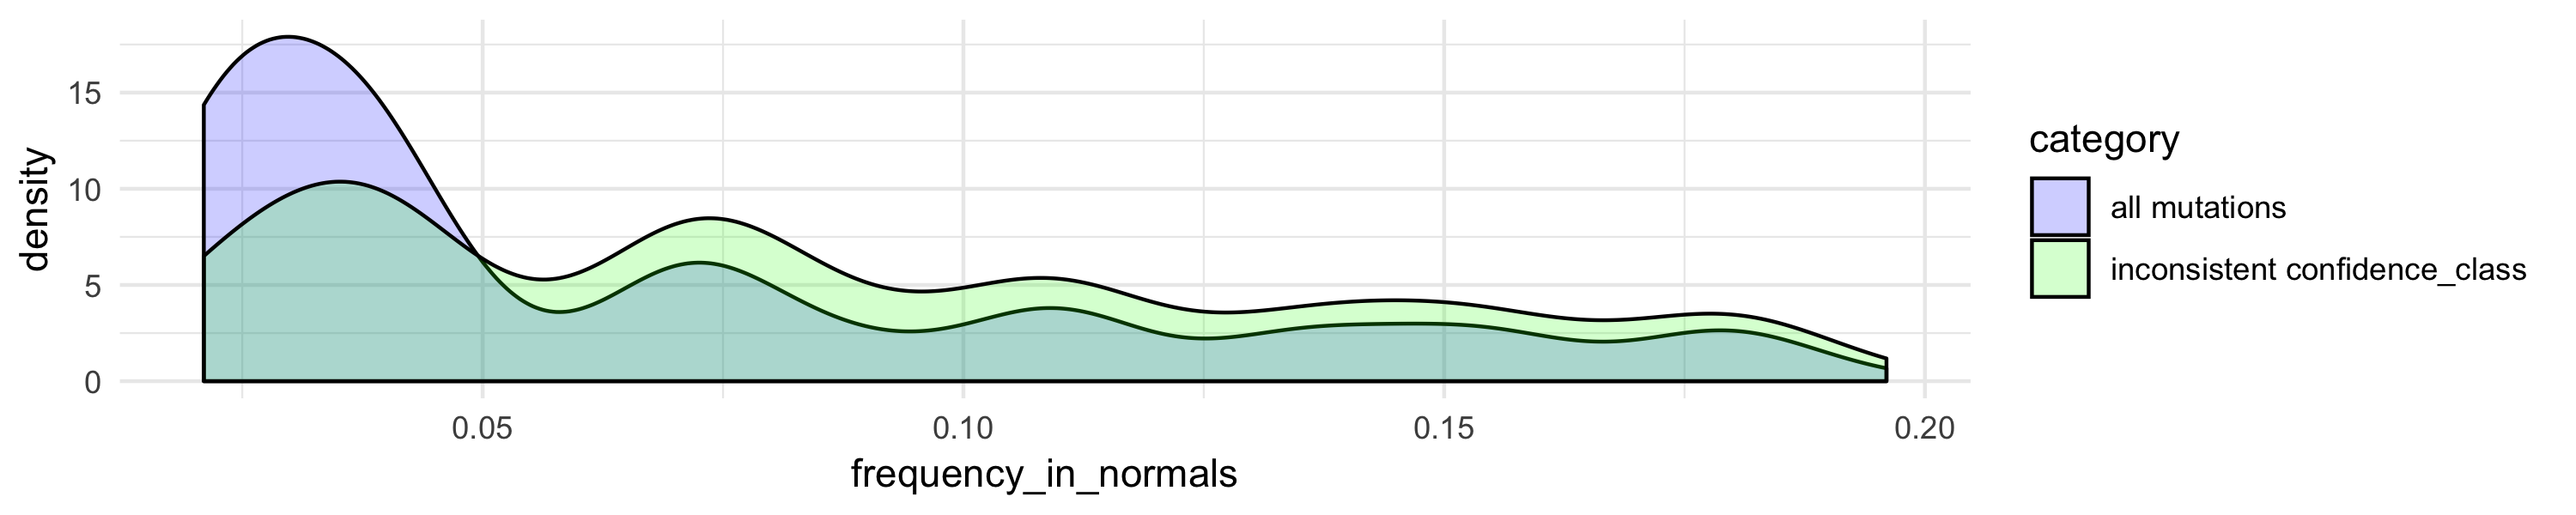

In [32]:
plot_density(dd[dd$frequency_in_normals != 0,], "frequency_in_normals", "category", height = 2)

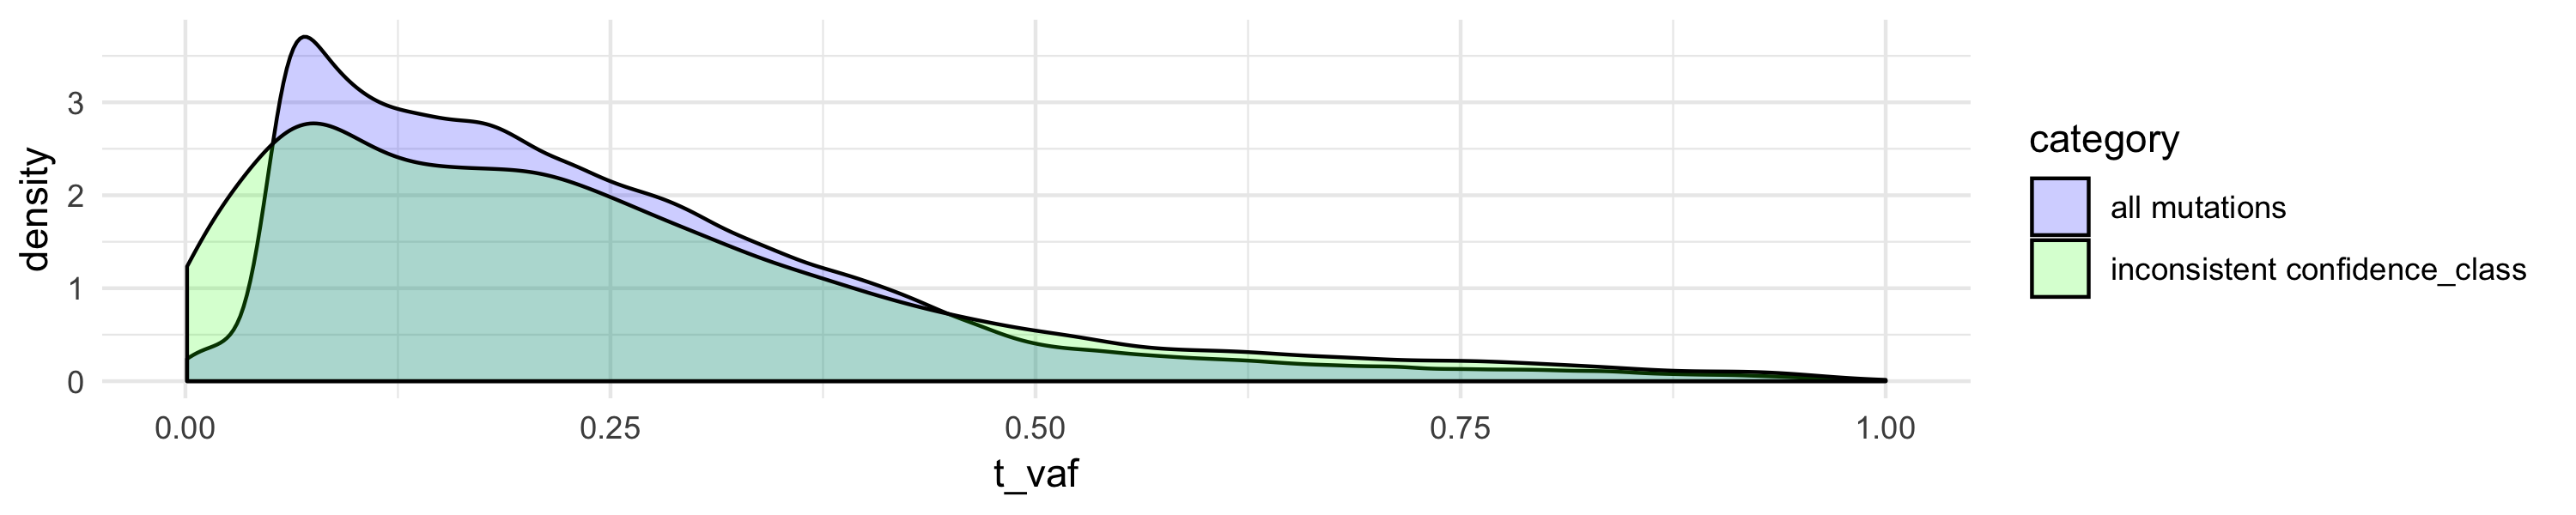

In [33]:
plot_density(dd, "t_vaf", "category", height = 2)

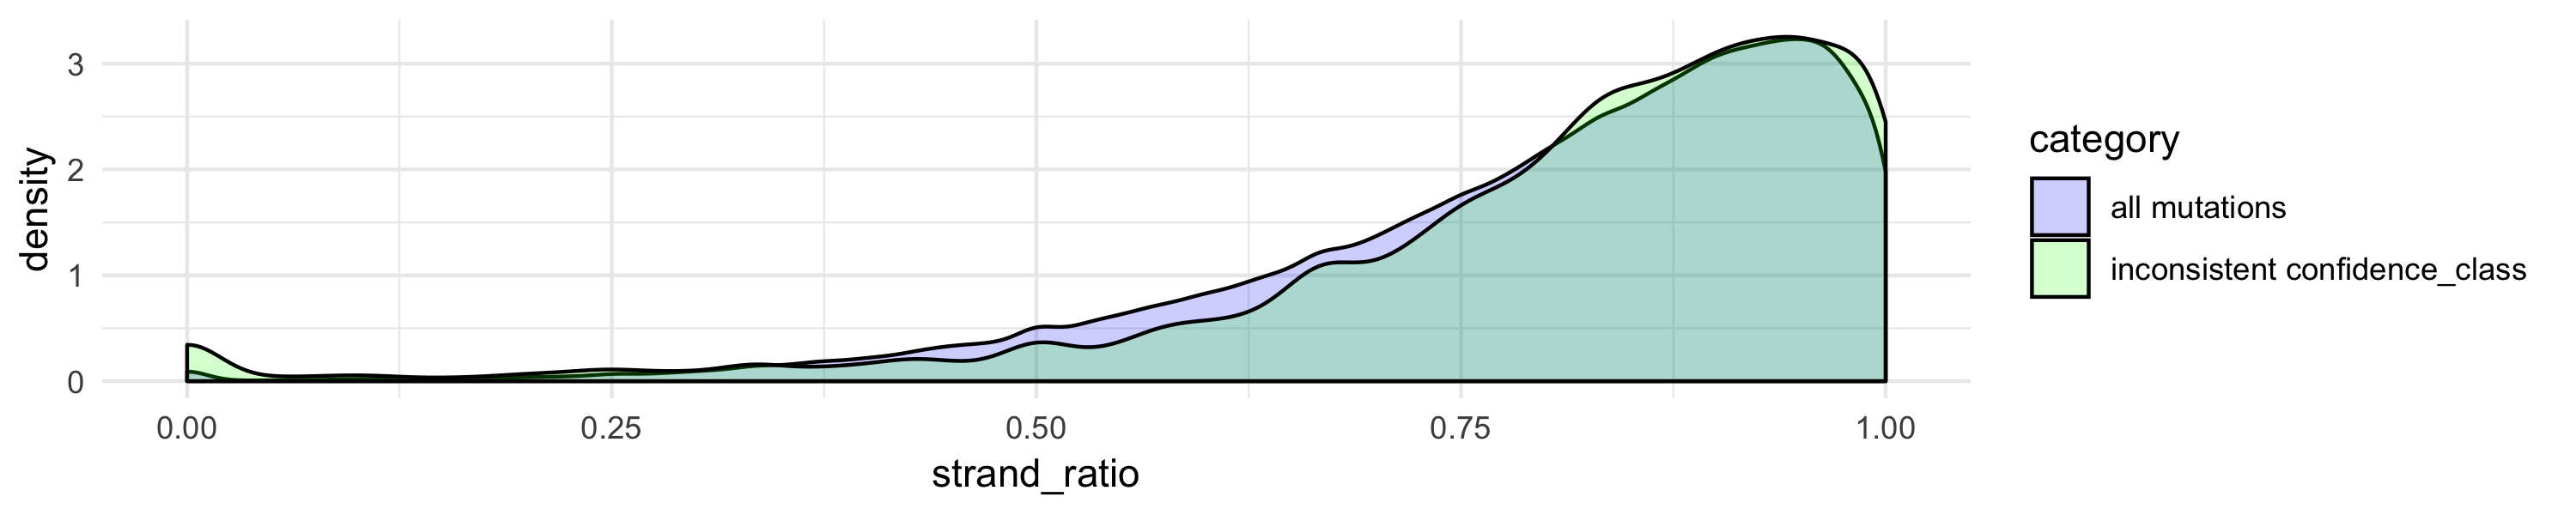

In [34]:
plot_density(dd, "strand_ratio", "category", height = 2)